# Bank of England Sentiment Analysis
## Employer Project
### Team 8 AnalytIQ, June 2nd, 2025
**Team Members**: Lalitha Vemuri, Christina Tsoulfa, Reka Bodo, Yann Hirsig, Louis Pang, Dr. Karin Agius Ferrante

## Content
1. Approach
2. Load the Data
4. Exploratory Sentiment Analysis & Natural Language Processing (NLP)
5. Exploratory Analysis for Correlation with Economic Indicators
8. Insights & Recommendations

## 1. Approach

The **Bank of England (BoE)**, the UK’s central bank and one of the world’s leading financial institutions, plays a pivotal role in maintaining economic and financial stability, and supporting the UK government’s economic policies. One of its key communication channels with the public and markets is through formal speeches delivered by its representatives. These speeches aim to offer guidance, manage expectations, and provide clarity in times of uncertainty.

However, the effectiveness and impact of these speeches on economic indicators and market behaviour are not fully understood. 

This project seeks to explore whether the sentiment and timing of BoE speeches hold analytical or predictive value, when compared with economic performance and key events.

### Main Business Questions
**Has the tone or sentiment of the BoE’s speeches evolved over time? If so, how?**<br>
**How do sentiments align with events like interest rate changes, policy reports, or major economic releases?**

**Sub-questions**

1.	Are there measurable correlations between speech sentiment and UK economic indicators such as inflation, GDP, employment rates and bond yields?
2. Does the change in sentiment change economic indicators or is the speech sentiment reactive to economic indicators?
3. Can speech sentiment trends be used to predict market reactions or economic outcomes?
4. What broader insights can be drawn to support data-informed communication strategies?

## 2. Load the Data

### 2.1. Import libraries

In [ ]:
# Install the necessary libraries.
# !pip install nltk
# !pip install vaderSentiment
# !pip install textblob
# !pip install pandas openpyxl
# !pip install transformers torch

In [ ]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('words')
# nltk.download('omw-1.4')

In [1]:
# General libraries
import numpy as np                             # Numerical operations and array handling.
import pandas as pd                            # Data manipulation and analysis.
import contractions                            # Expanding/contracting text contractions.
import re                                      # Regular expression operations on strings.
import os                                      # Interacting with the operating system and file handling.
import matplotlib.pyplot as plt                # Create visualisations.
from matplotlib.colors import rgb2hex          # Colour conversion in plots.
import seaborn as sns                          # Enhanced statistical data visualisations.
import math                                    # Mathematical functions and constants.
from IPython.display import display, Markdown  # Rich output in Jupyter.
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose   # Seasonality
import matplotlib.dates as mdates

In [2]:
# Text and Sentiment Analysis 
from wordcloud import WordCloud                                       # Generating visual word frequency clouds from text.
import nltk                                                           # Natural language processing tasks.
from nltk import word_tokenize, pos_tag                               # Splitting text into words and tags with part of speech
from nltk import defaultdict                                          # Providing default values for nonexistent keys.
from nltk.probability import FreqDist                                 # Calculating frequency distribution of tokens.
from nltk.corpus import stopwords                                     # Providing list of common words to exclude from analysis.
from nltk.corpus import words
from nltk.corpus import wordnet as wn                                 # Lexical database for retrieving word relationships & meanings.
from nltk.stem import WordNetLemmatizer, PorterStemmer                # Reducing words to base or root form.
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Assessing sentiment intensity in text.
from textblob import TextBlob                                         # API for text processing tasks including sentiment analysis.
import contractions                                                   # Expanding/contracting text contractions.
import re                                                             # Regular expression operations on strings.
import ast                                                            # If column contains string representations of lists
from collections import defaultdict  # Creating dictionaries that return default value for nonexistent keys.
from collections import Counter  # Importing Counter for counting hashable objects and efficiently tallying occurrences in an iterable.
from transformers import AutoTokenizer                                # FinBERT Model
from transformers import AutoModelForSequenceClassification           # FinBERT Model
import torch                                                          # FinBERT Model
import torch.nn.functional as F                                       # FinBERT Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
stop_words = set(stopwords.words('english'))

In [3]:
# Import warnings
import warnings
# Settings for the notebook.
warnings.filterwarnings("ignore")

In [4]:
# Set figure style for seaborn.
sns.set_theme(style='darkgrid')

### 2.2. Define functions

**2.2.a. Charts**

In [8]:
def clean_label(label):
    # If label is a Series, return its name.
    if isinstance(label, pd.Series):
        return label.name.replace('_', ' ').title() if label.name else ' '
    elif isinstance(label, str):
        return label.replace('_', ' ').title()
    return ' '

In [13]:
# Define function for scatterplot.
def generate_scatterplot(df, x_axis, y_axis, title, hue, save_path=None):

    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(8, 6)})

    # Plot the scatterplot.
    sns.scatterplot(data=df, x=x_axis, y=y_axis, hue=hue, color='#0e1b2c')

    # Customize the plot.
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=10)
    plt.ylabel(clean_label(y_axis), fontsize=10)

    # Add legend ONLY if hue is not None.
    if hue is not None:
        plt.legend(title='Legend', fontsize=10, bbox_to_anchor=(1.05,1), loc='upper left')
    
    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')

    # Display the chart.
    plt.tight_layout()
    plt.show()

In [15]:
# Define function to plot a lineplot.
def generate_lineplot(df, x_axis, y_axis, title, ylim=None, save_path=None, \
                      rotate_xticks=False):
    
    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Ensure time column is in datetime format.
    df[x_axis] = pd.to_datetime(df[x_axis])
    
    # Sort DataFrame by the time column.
    df.sort_values(by=x_axis, inplace=True)
    
    # Plot the lineplot.
    sns.lineplot(data=df, x=x_axis, y=y_axis, label=clean_label(y_axis))
    
    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)
    
    # Rotate x-tick labels by 45 degrees, if specified.
    if rotate_xticks:
        plt.xticks(rotation=45)
    
    # Set y-axis limits, if provided.
    if ylim:
        plt.ylim(ylim)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

**2.2.b. NLP analysis**

In [18]:
# Preprocessing function
def preprocess_text(text):
    text = contractions.fix(text)  # Expand contractions i.e I'm not good goes to I am not good
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub('#', '', text)         # Remove hashtags
    text = re.sub(r'\W', ' ', text)      # Remove special characters
    text = text.lower()                  # Convert to lowercase
    #Below is to create a set of stop words from the NLTK library's predefined list but not is excluded.
    stop_words = set(stopwords.words('english')) - {'not'} 
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [20]:
# Define the tag map for POS tagging.
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Lemmatise the tokens with correct POS tags.
lemma_function = WordNetLemmatizer()

# Lemmatisation function.
def lemmatize_tokens(tokens):
    #For each word in the token list, it lemmatizes the word with the correct part-of-speech
    lemmatized_tokens = [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]
    return lemmatized_tokens

In [21]:
# VADER Sentiment Intensity Analyzer.
analyzer = SentimentIntensityAnalyzer()

# Define the function to compute and return sentiment scores.
def analyse_sentiment(text):
    return analyzer.polarity_scores(' '.join(text))

In [24]:
# Define function to label sentiments.
def get_sentiment_label(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [26]:
# Define a function to extract a polarity score using TextBlob.
def generate_polarity(comment):
    return TextBlob(comment).sentiment[0]

In [28]:
# Define a function to extract a subjectivity score using TextBlob.
def generate_subjectivity(comment):
    return TextBlob(comment).sentiment[1]

### 2.3. Import and review the data

**2.3.a. Import Bank of England Speeches**

In [30]:
# Load the CSV file as speeches.
speeches_original = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/all_speeches.csv')

# View the data.
speeches_original.head()

,reference,country,date,title,author,is_gov,text
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh..."


In [31]:
# Explore data set.
speeches_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reference  7721 non-null   object
 1   country    7721 non-null   object
 2   date       7721 non-null   object
 3   title      7721 non-null   object
 4   author     7721 non-null   object
 5   is_gov     7721 non-null   int64 
 6   text       7721 non-null   object
dtypes: int64(1), object(6)
memory usage: 422.4+ KB


In [34]:
# Check for missing values.
speeches_original.isnull().sum()

reference    0
country      0
date         0
title        0
author       0
is_gov       0
text         0
dtype: int64

In [36]:
# Check for duplicates.
speeches_original.duplicated().sum()

0

In [38]:
# Review basic descriptive statistics.
speeches_original.describe()

,is_gov
count,7721.000000
mean,0.347235
std,0.476122
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [40]:
# View the countries.
speeches_original['country'].unique()

array(['australia', 'canada', 'euro area', 'japan', 'sweden',
       'switzerland', 'united kingdom', 'united states'], dtype=object)

In [42]:
# View the author.
speeches_original['author'].unique()

array(['fraser', 'macfarlane', 'lowe', 'stevens', 'no_info', 'ac',
       'thiessen', 'bonin', 'dodge', 'jenkins', 'kennedy', 'macklem',
       'duguay', 'longworth', 'carney', 'murray', 'lane', 'wolf',
       'boivin', 'cote', 'poloz', 'schembri', 'johnson', 'wilkins',
       'chilcott', 'mendes', 'patterson', 'murchison', 'leduc', 'dinis',
       'beaudry', 'gravelle', 'kozicki', 'rogers', 'morrow', 'lamfalussy',
       'duisenberg', 'vienna', 'london', 'tokyo', 'kong', 'bank',
       'schioppa', 'hamalainen', 'main', 'noyer', 'committee', 'solans',
       'francisco', 'istanbul', 'issing', 'hoogduin', 'bankwashington',
       'efma', 'brussels', 'forum', 'workshop', 'quiros', 'papademos',
       'gugerell', 'trichet', 'network', 'delivered', 'paramo',
       'strasbourg', 'rome', 'berlin', 'smaghi', 'sevilla', 'madrid',
       'stark', 'singapore', 'summit', 'washington', 'aires',
       'bratislava', 'ecb', 'constancio', 'posen', 'praet', 'draghi',
       'coeure', 'asmussen', 'mer

**2.3.b. Import Lexicon Sentiment based on BoE Wordlist**

In [45]:
# Load the Excel file of BoE sentiment labelled wordlist.
speeches = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/speeches_sentiment.csv')

# View the data.
speeches.head()

,reference,country,date,title,author,is_gov,text,text_norm,text_cleaned,text_tokenised,...,negative,positive,uncertainty,litigious,strong,weak,constraining,word_count_sentiment,sentiment_lexicon_simple,sentiment_lexicon_weighted
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...,they would no doubt argue that to have two obj...,would doubt argue two objectives like trying c...,"['would', 'doubt', 'argue', 'two', 'objectives...",...,84,58,32,5,10,15,13,217,-0.119816,0.112442
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...,today i wish to talk about real interest rates...,today wish talk real interest rates mainly his...,"['today', 'wish', 'talk', 'real', 'interest', ...",...,53,28,35,2,3,16,12,149,-0.167785,0.014094
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...,i welcome this opportunity to talk about prosp...,welcome opportunity talk prospects banks austr...,"['welcome', 'opportunity', 'talk', 'prospects'...",...,43,67,33,8,11,16,13,191,0.125654,0.421466
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...,it is a pleasure to have this opportunity to a...,pleasure opportunity address influential gathe...,"['pleasure', 'opportunity', 'address', 'influe...",...,62,56,43,6,7,20,8,202,-0.029703,0.227228
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh...","as a long-time fan of don sanders, i am deligh...",long time fan sanders delighted participating ...,"['long', 'time', 'fan', 'sanders', 'delighted'...",...,72,62,42,6,12,27,13,234,-0.042735,0.227350


In [46]:
# Explore data set.
speeches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   reference                   7721 non-null   object 
 1   country                     7721 non-null   object 
 2   date                        7721 non-null   object 
 3   title                       7721 non-null   object 
 4   author                      7721 non-null   object 
 5   is_gov                      7721 non-null   int64  
 6   text                        7721 non-null   object 
 7   text_norm                   7721 non-null   object 
 8   text_cleaned                7721 non-null   object 
 9   text_tokenised              7721 non-null   object 
 10  text_lemmatised             7721 non-null   object 
 11  text_lemmatised_str         7721 non-null   object 
 12  word_count_text             7721 non-null   int64  
 13  word_count_text_cleaned     7721 

In [47]:
# Check for missing values.
speeches.isnull().sum()

reference                     0
country                       0
date                          0
title                         0
author                        0
is_gov                        0
text                          0
text_norm                     0
text_cleaned                  0
text_tokenised                0
text_lemmatised               0
text_lemmatised_str           0
word_count_text               0
word_count_text_cleaned       0
negative                      0
positive                      0
uncertainty                   0
litigious                     0
strong                        0
weak                          0
constraining                  0
word_count_sentiment          0
sentiment_lexicon_simple      1
sentiment_lexicon_weighted    1
dtype: int64

In [48]:
# Check for duplicates.
speeches.duplicated().sum()

0

In [49]:
# Review basic descriptive statistics.
speeches.describe()

,is_gov,word_count_text,word_count_text_cleaned,negative,positive,uncertainty,litigious,strong,weak,constraining,word_count_sentiment,sentiment_lexicon_simple,sentiment_lexicon_weighted
count,7721.000000,7721.000000,7721.000000,7721.000000,7721.000000,7721.000000,7721.000000,7721.000000,7721.000000,7721.000000,7721.000000,7720.000000,7720.000000
mean,0.347235,3113.002072,1776.809222,68.278073,55.249968,45.351768,11.074343,5.342831,18.962958,11.482709,215.742650,-0.023593,0.201153
std,0.476122,2047.797030,1174.241676,55.675494,37.151788,43.173626,15.827917,4.827564,18.883414,12.094693,154.677042,0.179111,0.233669
min,0.000000,16.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.782609,-0.833333
25%,0.000000,1906.000000,1081.000000,31.000000,31.000000,19.000000,3.000000,2.000000,8.000000,5.000000,120.000000,-0.146341,0.039150
50%,0.000000,2904.000000,1656.000000,57.000000,49.000000,35.000000,6.000000,4.000000,15.000000,9.000000,195.000000,-0.039832,0.179004
75%,1.000000,3879.000000,2219.000000,91.000000,71.000000,60.000000,14.000000,7.000000,25.000000,15.000000,277.000000,0.082904,0.341438
max,1.000000,37522.000000,23119.000000,1251.000000,1042.000000,893.000000,351.000000,70.000000,422.000000,262.000000,3206.000000,1.000000,1.500000


In [50]:
# Check the number of unique values.
speeches.nunique()

reference                     7721
country                          8
date                          4410
title                         6218
author                         325
is_gov                           2
text                          7692
text_norm                     7692
text_cleaned                  7691
text_tokenised                7691
text_lemmatised               7691
text_lemmatised_str           7691
word_count_text               4183
word_count_text_cleaned       3074
negative                       293
positive                       225
uncertainty                    245
litigious                      120
strong                          42
weak                           126
constraining                    98
word_count_sentiment           681
sentiment_lexicon_simple      5426
sentiment_lexicon_weighted    7276
dtype: int64

In [51]:
# Create a normalized version of the 'text' column
speeches['text_norm'] = speeches['text'].str.strip().str.lower()

# Find duplicate 'text_norm' entries
duplicate_mask = speeches['text_norm'].duplicated(keep=False)

# Extract all duplicates based on normalized text
duplicates = speeches[duplicate_mask]

In [52]:
# Show the 'text' of these duplicates
duplicates

,reference,country,date,title,author,is_gov,text,text_norm,text_cleaned,text_tokenised,...,negative,positive,uncertainty,litigious,strong,weak,constraining,word_count_sentiment,sentiment_lexicon_simple,sentiment_lexicon_weighted
564,r101026a_BOC,canada,2010-10-26,Opening Statement before the House of Commons ...,carney,1,"Governor of the Bank of Canada Good afternoon,...","governor of the bank of canada good afternoon,...",governor bank canada good afternoon mr chairma...,"['governor', 'bank', 'canada', 'good', 'aftern...",...,15,20,19,0,0,3,4,61,0.081967,0.300000
565,r101027a_BOC,canada,2010-10-27,Opening Statement before the Standing Senate C...,carney,1,"Governor of the Bank of Canada Good afternoon,...","governor of the bank of canada good afternoon,...",governor bank canada good afternoon mr chairma...,"['governor', 'bank', 'canada', 'good', 'aftern...",...,15,20,19,0,0,3,4,61,0.081967,0.300000
610,r120424a_BOC,canada,2012-04-24,Opening Statement before the House of Commons ...,carney,1,Governor of the Bank of Canada Good afternoon....,governor of the bank of canada good afternoon....,governor bank canada good afternoon tiff pleas...,"['governor', 'bank', 'canada', 'good', 'aftern...",...,11,21,20,0,0,8,0,60,0.166667,0.475000
611,r120425a_BOC,canada,2012-04-25,Opening Statement before the Senate Standing C...,carney,1,Governor of the Bank of Canada Good afternoon....,governor of the bank of canada good afternoon....,governor bank canada good afternoon tiff pleas...,"['governor', 'bank', 'canada', 'good', 'aftern...",...,11,21,20,0,0,8,0,60,0.166667,0.475000
624,r121030a_BOC,canada,2012-10-30,Opening Statement before the House of Commons ...,carney,1,Governor of the Bank of Canada Good afternoon....,governor of the bank of canada good afternoon....,governor bank canada good afternoon tiff pleas...,"['governor', 'bank', 'canada', 'good', 'aftern...",...,20,23,16,1,0,6,2,68,0.044118,0.286765
625,r121031a_BOC,canada,2012-10-31,Opening Statement before the Standing Senate C...,carney,1,Governor of the Bank of Canada Good afternoon....,governor of the bank of canada good afternoon....,governor bank canada good afternoon tiff pleas...,"['governor', 'bank', 'canada', 'good', 'aftern...",...,20,23,16,1,0,6,2,68,0.044118,0.286765
668,r140429a_BOC,canada,2014-04-29,Opening Statement before the House of Commons ...,poloz,1,Governor of the Bank of Canada Thank you for t...,governor of the bank of canada thank you for t...,governor bank canada thank opportunity tiff to...,"['governor', 'bank', 'canada', 'thank', 'oppor...",...,21,31,21,0,1,6,3,83,0.120482,0.393976
669,r140430a_BOC,canada,2014-04-30,Opening Statement before the Senate Standing C...,poloz,1,Governor of the Bank of Canada Thank you for t...,governor of the bank of canada thank you for t...,governor bank canada thank opportunity tiff to...,"['governor', 'bank', 'canada', 'thank', 'oppor...",...,21,31,21,0,1,6,3,83,0.120482,0.393976
1182,r020121a_ECB,euro area,2002-01-21,Securities and banking: bridges and walls,no_info,0,I once again find myself speaking at the Londo...,i once again find myself speaking at the londo...,find speaking london school economics mileston...,"['find', 'speaking', 'london', 'school', 'econ...",...,143,108,157,70,8,46,25,557,-0.062837,0.105745
1186,r020221a_ECB,euro area,2002-02-21,Securities and banking: bridges and walls,schioppa,0,I once again find myself speaking at the Londo...,i once again find myself speaking at the londo...,find speaking london school economics mileston...,"['find', 'speaking', 'london', 'school', 'econ...",...,143,108,157,70,8,46,25,557,-0.062837,0.105745


In [56]:
# Export to csv
# duplicates.to_csv('/Users/kaferrante/Documents/Python/_Course4_Project/duplicates_full_rows.csv', index=False)

**2.3.c. Import BoE Wordlist**

In [63]:
# Load the Excel file of BoE sentiment labelled wordlist.
sentiment_lexicon = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/sentiment_labelled_wordlist.xlsx')

# View the data.
sentiment_lexicon.head()

,Word,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
0,ABANDON,1,0,0,0,0,0,0
1,ABANDONED,1,0,0,0,0,0,0
2,ABANDONING,1,0,0,0,0,0,0
3,ABANDONMENT,1,0,0,0,0,0,0
4,ABANDONMENTS,1,0,0,0,0,0,0


In [65]:
# Explore data set.
sentiment_lexicon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Word          3880 non-null   object
 1   Negative      3880 non-null   int64 
 2   Positive      3880 non-null   int64 
 3   Uncertainty   3880 non-null   int64 
 4   Litigious     3880 non-null   int64 
 5   Strong        3880 non-null   int64 
 6   Weak          3880 non-null   int64 
 7   Constraining  3880 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 242.6+ KB


In [67]:
# Check for missing values.
sentiment_lexicon.isnull().sum()

Word            0
Negative        0
Positive        0
Uncertainty     0
Litigious       0
Strong          0
Weak            0
Constraining    0
dtype: int64

In [69]:
# Review basic descriptive statistics.
sentiment_lexicon.describe()

,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
count,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000
mean,0.606959,0.092268,0.076546,0.233247,0.004897,0.006959,0.047423
std,0.488489,0.289441,0.265905,0.422953,0.069815,0.083139,0.212569
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**2.3.d. Import UK Economic Indicators (1998-2025)**

In [72]:
# Load the Excel file for UK Economic Indicators
uk_economic_indicators = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/Consolidated_Eco_KPI _V3.xlsx')

# View the data.
uk_economic_indicators.head()

,year,month,year_month,uk_inflation_rate_CPIH,uk_unemployment_rate,uk_gdp_growth,uk_interest_rate,uk_consumer_confidence,gbp_usd_fx,ftse_250,gilts_short,gilts_medium,gilts_long,uk_credit_growth_no_cc,uk_credit_growth_only_cc,avg_price_all_property_types
0,1998,4,1998-04,1.815,6.3,0.6,7.25,1.1,1.673270,5554.720972,5.91,5.70,5.71,14.1,24.7,64258
1,1998,5,1998-05,2.039,6.3,0.6,7.25,1.2,1.636589,5799.256322,5.82,5.57,5.55,14.4,24.5,64258
2,1998,6,1998-06,1.675,6.3,0.6,7.50,-1.3,1.650718,5739.277233,6.17,5.64,5.43,13.9,25.5,64258
3,1998,7,1998-07,1.443,6.3,0.3,7.50,-4.3,1.643657,5595.919582,6.06,5.57,5.38,14.6,25.6,67057
4,1998,8,1998-08,1.327,6.2,0.3,7.50,-6.5,1.631950,5173.355054,5.52,5.19,5.11,14.6,26.1,67057


In [74]:
# Explore data set.
uk_economic_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          321 non-null    int64  
 1   month                         321 non-null    int64  
 2   year_month                    321 non-null    object 
 3   uk_inflation_rate_CPIH        321 non-null    float64
 4   uk_unemployment_rate          321 non-null    float64
 5   uk_gdp_growth                 321 non-null    float64
 6   uk_interest_rate              321 non-null    float64
 7   uk_consumer_confidence        321 non-null    float64
 8   gbp_usd_fx                    321 non-null    float64
 9   ftse_250                      321 non-null    float64
 10  gilts_short                   321 non-null    float64
 11  gilts_medium                  321 non-null    float64
 12  gilts_long                    321 non-null    float64
 13  uk_cr

In [76]:
# Check for missing values.
uk_economic_indicators.isnull().sum()

year                            0
month                           0
year_month                      0
uk_inflation_rate_CPIH          0
uk_unemployment_rate            0
uk_gdp_growth                   0
uk_interest_rate                0
uk_consumer_confidence          0
gbp_usd_fx                      0
ftse_250                        0
gilts_short                     0
gilts_medium                    0
gilts_long                      0
uk_credit_growth_no_cc          0
uk_credit_growth_only_cc        0
avg_price_all_property_types    0
dtype: int64

In [78]:
# View column types.
uk_economic_indicators.dtypes

year                              int64
month                             int64
year_month                       object
uk_inflation_rate_CPIH          float64
uk_unemployment_rate            float64
uk_gdp_growth                   float64
uk_interest_rate                float64
uk_consumer_confidence          float64
gbp_usd_fx                      float64
ftse_250                        float64
gilts_short                     float64
gilts_medium                    float64
gilts_long                      float64
uk_credit_growth_no_cc          float64
uk_credit_growth_only_cc        float64
avg_price_all_property_types      int64
dtype: object

### 2.4. Date Transformation

**Speeches**

In [80]:
# Determine the date format for speeches.
speeches.date.head()

0    1990-11-28
1    1991-10-03
2    1992-03-14
3    1992-05-29
4    1992-08-17
Name: date, dtype: object

In [82]:
# Change date format from 'object' to 'datetime64' and display in a new column
speeches['date_format'] = speeches['date'].astype('datetime64[ns]')

In [84]:
# Add a new column for year and month
speeches['year_month'] = pd.to_datetime(speeches['date_format']).dt.to_period('M')

In [86]:
# Add a new column for year only
speeches['year'] = pd.to_datetime(speeches.date).dt.year

In [88]:
# Add a column for year_month in date format
speeches['year_month_dt'] = speeches['year_month'].dt.to_timestamp()

In [90]:
# View the DataFrame.
speeches.head()

,reference,country,date,title,author,is_gov,text,text_norm,text_cleaned,text_tokenised,...,strong,weak,constraining,word_count_sentiment,sentiment_lexicon_simple,sentiment_lexicon_weighted,date_format,year_month,year,year_month_dt
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...,they would no doubt argue that to have two obj...,would doubt argue two objectives like trying c...,"['would', 'doubt', 'argue', 'two', 'objectives...",...,10,15,13,217,-0.119816,0.112442,1990-11-28,1990-11,1990,1990-11-01
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...,today i wish to talk about real interest rates...,today wish talk real interest rates mainly his...,"['today', 'wish', 'talk', 'real', 'interest', ...",...,3,16,12,149,-0.167785,0.014094,1991-10-03,1991-10,1991,1991-10-01
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...,i welcome this opportunity to talk about prosp...,welcome opportunity talk prospects banks austr...,"['welcome', 'opportunity', 'talk', 'prospects'...",...,11,16,13,191,0.125654,0.421466,1992-03-14,1992-03,1992,1992-03-01
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...,it is a pleasure to have this opportunity to a...,pleasure opportunity address influential gathe...,"['pleasure', 'opportunity', 'address', 'influe...",...,7,20,8,202,-0.029703,0.227228,1992-05-29,1992-05,1992,1992-05-01
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh...","as a long-time fan of don sanders, i am deligh...",long time fan sanders delighted participating ...,"['long', 'time', 'fan', 'sanders', 'delighted'...",...,12,27,13,234,-0.042735,0.227350,1992-08-17,1992-08,1992,1992-08-01


In [92]:
# View column types.
speeches.dtypes

reference                             object
country                               object
date                                  object
title                                 object
author                                object
is_gov                                 int64
text                                  object
text_norm                             object
text_cleaned                          object
text_tokenised                        object
text_lemmatised                       object
text_lemmatised_str                   object
word_count_text                        int64
word_count_text_cleaned                int64
negative                               int64
positive                               int64
uncertainty                            int64
litigious                              int64
strong                                 int64
weak                                   int64
constraining                           int64
word_count_sentiment                   int64
sentiment_

**Indicators**

In [96]:
# Add a new column for year and month.
uk_economic_indicators['year_month'] = pd.to_datetime(uk_economic_indicators['year_month']).dt.to_period('M')

In [98]:
# View the DataFrame.
uk_economic_indicators.head()

,year,month,year_month,uk_inflation_rate_CPIH,uk_unemployment_rate,uk_gdp_growth,uk_interest_rate,uk_consumer_confidence,gbp_usd_fx,ftse_250,gilts_short,gilts_medium,gilts_long,uk_credit_growth_no_cc,uk_credit_growth_only_cc,avg_price_all_property_types
0,1998,4,1998-04,1.815,6.3,0.6,7.25,1.1,1.673270,5554.720972,5.91,5.70,5.71,14.1,24.7,64258
1,1998,5,1998-05,2.039,6.3,0.6,7.25,1.2,1.636589,5799.256322,5.82,5.57,5.55,14.4,24.5,64258
2,1998,6,1998-06,1.675,6.3,0.6,7.50,-1.3,1.650718,5739.277233,6.17,5.64,5.43,13.9,25.5,64258
3,1998,7,1998-07,1.443,6.3,0.3,7.50,-4.3,1.643657,5595.919582,6.06,5.57,5.38,14.6,25.6,67057
4,1998,8,1998-08,1.327,6.2,0.3,7.50,-6.5,1.631950,5173.355054,5.52,5.19,5.11,14.6,26.1,67057


In [100]:
# View column types.
uk_economic_indicators.dtypes

year                                int64
month                               int64
year_month                      period[M]
uk_inflation_rate_CPIH            float64
uk_unemployment_rate              float64
uk_gdp_growth                     float64
uk_interest_rate                  float64
uk_consumer_confidence            float64
gbp_usd_fx                        float64
ftse_250                          float64
gilts_short                       float64
gilts_medium                      float64
gilts_long                        float64
uk_credit_growth_no_cc            float64
uk_credit_growth_only_cc          float64
avg_price_all_property_types        int64
dtype: object

### 2.5. Data Correction

**2.5.a Author 'Edward George' wrongly not stated as governor**

In [102]:
# Speeches given by Edward George are wrongly not stated as is_gov
def correct_is_gov_column(speeches_df: pd.DataFrame):
    # Make sure date is datetime first
    speeches['date'] = pd.to_datetime(speeches['date'], errors='coerce')
    
    # Apply correction
    condition = (
        (speeches['author'].str.lower() == 'george') &
        (speeches['date'].dt.year > 1993) &
        (speeches['date'].dt.year < 2004)
    )
    speeches.loc[condition, 'is_gov'] = 1  # 1 means Governor
    
    return speeches

# Correct the is_gov column
speeches = correct_is_gov_column(speeches)

# View the DataFrame
display(speeches[speeches['author'].str.lower() == 'george'].head())

,reference,country,date,title,author,is_gov,text,text_norm,text_cleaned,text_tokenised,...,strong,weak,constraining,word_count_sentiment,sentiment_lexicon_simple,sentiment_lexicon_weighted,date_format,year_month,year,year_month_dt
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...","thank you, chairman. i'm actually very pleased...",thank chairman actually pleased opportunity re...,"['thank', 'chairman', 'actually', 'pleased', '...",...,14,16,2,160,-0.143750,0.179375,1998-09-15,1998-09,1998,1998-09-01
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,it's a great pleasure to be here in the beauti...,great pleasure beautiful city bruges honoured ...,"['great', 'pleasure', 'beautiful', 'city', 'br...",...,10,28,17,280,0.028571,0.291071,1998-10-21,1998-10,1998,1998-10-01
4966,r981119a_BOE,united kingdom,1998-11-19,Speech,george,1,Let me put some of the recent newspaper headli...,let me put some of the recent newspaper headli...,let put recent newspaper headlines alongside f...,"['let', 'put', 'recent', 'newspaper', 'headlin...",...,7,14,3,162,-0.185185,0.069136,1998-11-19,1998-11,1998,1998-11-01
4969,r990112a_BOE,united kingdom,1999-01-12,Speech,george,1,I am only too well aware of the pressure curre...,i am only too well aware of the pressure curre...,well aware pressure currently facing large par...,"['well', 'aware', 'pressure', 'currently', 'fa...",...,4,20,3,195,-0.194872,0.022051,1999-01-12,1999-01,1999,1999-01-01
4970,r990118a_BOE,united kingdom,1999-01-18,Speech,george,1,It would be a masterly understatement to descr...,it would be a masterly understatement to descr...,would masterly understatement describe past tw...,"['would', 'masterly', 'understatement', 'descr...",...,3,11,9,168,-0.059524,0.149405,1999-01-18,1999-01,1999,1999-01-01


**2.5.b Remove Date Outlier**

In [104]:
# Check for earliest and latest dates
min_year = speeches['year'].min()
max_year = speeches['year'].max()

print(f"Minimum year: {min_year}")
print(f"Maximum year: {max_year}")

Minimum year: 1900
Maximum year: 2022


In [106]:
# Filter for speeches in year 1900
speeches_1900 = speeches[speeches['year'] == 1900]

# View the DataFrame
speeches_1900

,reference,country,date,title,author,is_gov,text,text_norm,text_cleaned,text_tokenised,...,strong,weak,constraining,word_count_sentiment,sentiment_lexicon_simple,sentiment_lexicon_weighted,date_format,year_month,year,year_month_dt
4010,r000101a_SRB,sweden,1900-01-01,Swedish economy in transition,backstrom,1,Thank you for inviting me to talk with you thi...,thank you for inviting me to talk with you thi...,thank inviting talk evening swedish economy mo...,"['thank', 'inviting', 'talk', 'evening', 'swed...",...,11,32,5,260,0.157692,0.491923,1900-01-01,1900-01,1900,1900-01-01


In [108]:
# Remove the specific row with index 4010, as the date must be wrongly entered, as dates on start in 1990
# Backstrom was governor of the Bank of Sweden from 1994 to 2002.
speeches = speeches.drop(4010)

In [110]:
# Check for earliest and latest dates
min_year = speeches['year'].min()
max_year = speeches['year'].max()

print(f"Minimum year: {min_year}")
print(f"Maximum year: {max_year}")

Minimum year: 1990
Maximum year: 2022


**2.5.c. Standardise Scores**

In [113]:
# Calculate mean and std
mean_score_simple = speeches['sentiment_lexicon_simple'].mean()
std_score_simple = speeches['sentiment_lexicon_simple'].std()

# Standardize
speeches['sentiment_lexicon_simple_std'] = (speeches['sentiment_lexicon_simple'] - mean_score_simple) / std_score_simple

In [115]:
# Calculate mean and std
mean_score_weighted = speeches['sentiment_lexicon_weighted'].mean()
std_score_weighted = speeches['sentiment_lexicon_weighted'].std()

# Standardize
speeches['sentiment_lexicon_weighted_std'] = (speeches['sentiment_lexicon_weighted'] - mean_score_weighted) / std_score_weighted

In [117]:
# View the DataFrame
speeches.head()

,reference,country,date,title,author,is_gov,text,text_norm,text_cleaned,text_tokenised,...,constraining,word_count_sentiment,sentiment_lexicon_simple,sentiment_lexicon_weighted,date_format,year_month,year,year_month_dt,sentiment_lexicon_simple_std,sentiment_lexicon_weighted_std
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...,they would no doubt argue that to have two obj...,would doubt argue two objectives like trying c...,"['would', 'doubt', 'argue', 'two', 'objectives...",...,13,217,-0.119816,0.112442,1990-11-28,1990-11,1990,1990-11-01,-0.537091,-0.379494
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...,today i wish to talk about real interest rates...,today wish talk real interest rates mainly his...,"['today', 'wish', 'talk', 'real', 'interest', ...",...,12,149,-0.167785,0.014094,1991-10-03,1991-10,1991,1991-10-01,-0.804912,-0.800397
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...,i welcome this opportunity to talk about prosp...,welcome opportunity talk prospects banks austr...,"['welcome', 'opportunity', 'talk', 'prospects'...",...,13,191,0.125654,0.421466,1992-03-14,1992-03,1992,1992-03-01,0.833403,0.943040
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...,it is a pleasure to have this opportunity to a...,pleasure opportunity address influential gathe...,"['pleasure', 'opportunity', 'address', 'influe...",...,8,202,-0.029703,0.227228,1992-05-29,1992-05,1992,1992-05-01,-0.033979,0.111755
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh...","as a long-time fan of don sanders, i am deligh...",long time fan sanders delighted participating ...,"['long', 'time', 'fan', 'sanders', 'delighted'...",...,13,234,-0.042735,0.227350,1992-08-17,1992-08,1992,1992-08-01,-0.106739,0.112280


### 2.6. Review of Economic Events

### 2000s
- **2003 Introduction of the BoE Inflation Target**: BoE formalised its inflation targeting policy, focusing on controlling inflation through monetary policy
- **2005 London Bombings**: economic impact included effects on the tourism and hospitality sectors
- **2008 Global Financial Crisis**: UK’s economy entered a recession, banks faced collapse, and extensive government interventions were implemented.

### 2010s
- **2010 Austerity Measures**: UK government, under David Cameron, implemented austerity policies to reduce budget deficits post-2008 crisis.
- **2016 Brexit Referendum**: UK voted to leave the EU, causing significant economic uncertainty, currency depreciation, and market volatility.
- **2017 Post-Brexit Currency Shock**: The pound fell sharply after the Brexit vote, increasing inflation and impacting consumer prices.
- **2018-2020 Economic Growth and Challenges**: UK faced slow growth, investment uncertainties, and the beginning of the COVID-19 pandemic impact.

### 2020s
- **2020 COVID-19 Pandemic**: Massive economic disruption worldwide, with the UK-government introducing support measures like the furlough scheme and emergency loans. GDP contracted by around 9.9% in 2020.
- **2021-2022 Post-Pandemic Recovery**: Efforts to recover growth, inflation concerns, labor shortages, and supply chain disruptions.
- **2021-2022 Inflation Surge**: Rising inflation due to supply chain bottlenecks, energy prices, and post-pandemic demand.
- **2021-2022 Energy Price Shock**: Rising energy costs affected households and industries.
- **2022 Interest Rate Hikes**: BoE increased interest rates to curb inflation.

## 3. Exploratory Analysis

### 3.1. Prepare the DataFrames

**3.1.a. All countries**

In [119]:
# Review columns in speeches DataFrame
speeches.columns

Index(['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
       'text_norm', 'text_cleaned', 'text_tokenised', 'text_lemmatised',
       'text_lemmatised_str', 'word_count_text', 'word_count_text_cleaned',
       'negative', 'positive', 'uncertainty', 'litigious', 'strong', 'weak',
       'constraining', 'word_count_sentiment', 'sentiment_lexicon_simple',
       'sentiment_lexicon_weighted', 'date_format', 'year_month', 'year',
       'year_month_dt', 'sentiment_lexicon_simple_std',
       'sentiment_lexicon_weighted_std'],
      dtype='object')

In [121]:
# Remove unnecessary columns
speeches_short = speeches[['reference', 'country', 'date_format', 'year_month', 'year',
       'year_month_dt', 'title', 'author', 'is_gov', 'text', 'text_lemmatised',
       'text_lemmatised_str', 'word_count_text', 'word_count_text_cleaned',
       'sentiment_lexicon_simple', 'sentiment_lexicon_simple_std', 'sentiment_lexicon_weighted', 
       'sentiment_lexicon_weighted_std']]

# View the DataFrame
speeches_short.head()

,reference,country,date_format,year_month,year,year_month_dt,title,author,is_gov,text,text_lemmatised,text_lemmatised_str,word_count_text,word_count_text_cleaned,sentiment_lexicon_simple,sentiment_lexicon_simple_std,sentiment_lexicon_weighted,sentiment_lexicon_weighted_std
0,r901128a_BOA,australia,1990-11-28,1990-11,1990,1990-11-01,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...,"['would', 'doubt', 'argue', 'two', 'objective'...",would doubt argue two objective like try cake ...,3627,1919,-0.119816,-0.537091,0.112442,-0.379494
1,r911003a_BOA,australia,1991-10-03,1991-10,1991,1991-10-01,,fraser,0,Today I wish to talk about real interest rates...,"['today', 'wish', 'talk', 'real', 'interest', ...",today wish talk real interest rate mainly hist...,3054,1754,-0.167785,-0.804912,0.014094,-0.800397
2,r920314a_BOA,australia,1992-03-14,1992-03,1992,1992-03-01,,fraser,0,I welcome this opportunity to talk about prosp...,"['welcome', 'opportunity', 'talk', 'prospect',...",welcome opportunity talk prospect bank austral...,3399,1867,0.125654,0.833403,0.421466,0.943040
3,r920529a_BOA,australia,1992-05-29,1992-05,1992,1992-05-01,,fraser,0,It is a pleasure to have this opportunity to a...,"['pleasure', 'opportunity', 'address', 'influe...",pleasure opportunity address influential gathe...,3841,2123,-0.029703,-0.033979,0.227228,0.111755
4,r920817a_BOA,australia,1992-08-17,1992-08,1992,1992-08-01,,fraser,0,"As a long-time fan of Don Sanders, I am deligh...","['long', 'time', 'fan', 'sander', 'delight', '...",long time fan sander delight participate tribu...,4152,2150,-0.042735,-0.106739,0.227350,0.112280


**3.1.b. BoE Speeches only**

In [124]:
# Bank OF England (UK) Speeches Only  
boe_speeches = speeches_short[speeches_short['country'].str.lower() == 'united kingdom'].copy()

# View the Dataframe
boe_speeches.head()

,reference,country,date_format,year_month,year,year_month_dt,title,author,is_gov,text,text_lemmatised,text_lemmatised_str,word_count_text,word_count_text_cleaned,sentiment_lexicon_simple,sentiment_lexicon_simple_std,sentiment_lexicon_weighted,sentiment_lexicon_weighted_std
4961,r980915a_BOE,united kingdom,1998-09-15,1998-09,1998,1998-09-01,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...","['thank', 'chairman', 'actually', 'pleased', '...",thank chairman actually pleased opportunity re...,2387,1162,-0.143750,-0.670720,0.179375,-0.093041
4962,r981021b_BOE,united kingdom,1998-10-21,1998-10,1998,1998-10-01,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,"['great', 'pleasure', 'beautiful', 'city', 'br...",great pleasure beautiful city bruges honour op...,4045,2108,0.028571,0.291375,0.291071,0.384988
4963,r981021a_BOE,united kingdom,1998-10-21,1998-10,1998,1998-10-01,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,"['industry', 'suffer', 'volatility', 'british'...",industry suffer volatility british economy pas...,2311,1240,-0.182353,-0.886246,0.020000,-0.775121
4964,r981101a_BOE,united kingdom,1998-11-01,1998-11,1998,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,"['topic', 'evening', 'use', 'forecast', 'econo...",topic evening use forecast economic policy mak...,4690,2380,-0.125424,-0.568402,0.116271,-0.363107
4965,r981101b_BOE,united kingdom,1998-11-01,1998-11,1998,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...","['six', 'year', 'ago', 'week', 'sterling', 'le...",six year ago week sterling leave exchange rate...,4452,2580,-0.157303,-0.746390,0.063764,-0.587823


In [126]:
# Prepare indicator dataframe for merge
uk_economic_indicators_merge = uk_economic_indicators.drop(columns=['year', 'month'])

# View the DataFrame
uk_economic_indicators_merge

,year_month,uk_inflation_rate_CPIH,uk_unemployment_rate,uk_gdp_growth,uk_interest_rate,uk_consumer_confidence,gbp_usd_fx,ftse_250,gilts_short,gilts_medium,gilts_long,uk_credit_growth_no_cc,uk_credit_growth_only_cc,avg_price_all_property_types
0,1998-04,1.815,6.3,0.6,7.25,1.10,1.673270,5554.720972,5.910000,5.700000,5.710000,14.1,24.7,64258
1,1998-05,2.039,6.3,0.6,7.25,1.20,1.636589,5799.256322,5.820000,5.570000,5.550000,14.4,24.5,64258
2,1998-06,1.675,6.3,0.6,7.50,-1.30,1.650718,5739.277233,6.170000,5.640000,5.430000,13.9,25.5,64258
3,1998-07,1.443,6.3,0.3,7.50,-4.30,1.643657,5595.919582,6.060000,5.570000,5.380000,14.6,25.6,67057
4,1998-08,1.327,6.2,0.3,7.50,-6.50,1.631950,5173.355054,5.520000,5.190000,5.110000,14.6,26.1,67057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,2024-08,2.216,4.3,0.0,5.00,-7.25,1.293286,20908.952720,3.843331,3.949251,4.480954,6.6,9.9,266225
317,2024-09,1.680,4.3,0.0,5.00,-15.50,1.321781,20841.357310,3.755558,3.895691,4.464948,6.6,9.5,266398
318,2024-10,2.281,4.4,0.1,5.00,-15.25,1.304578,20817.302486,4.040317,4.177002,4.703413,6.3,9.4,267358
319,2024-11,2.622,4.4,0.1,4.75,-13.00,1.274986,20517.825545,4.302807,4.430016,4.886294,6.0,8.0,267946


In [128]:
# List of DataFrames to merge
dataframes_to_merge = [uk_economic_indicators_merge]

# Use reduce to merge all DataFrames in the list
boe_speeches_indicators = reduce(lambda left, right: left.merge(right, on='year_month', how='left'), dataframes_to_merge, boe_speeches)

# View the merged DataFrame
boe_speeches_indicators.head()

,reference,country,date_format,year_month,year,year_month_dt,title,author,is_gov,text,...,uk_interest_rate,uk_consumer_confidence,gbp_usd_fx,ftse_250,gilts_short,gilts_medium,gilts_long,uk_credit_growth_no_cc,uk_credit_growth_only_cc,avg_price_all_property_types
0,r980915a_BOE,united kingdom,1998-09-15,1998-09,1998,1998-09-01,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",...,7.50,-4.9,1.682209,4657.921320,5.00,4.80,4.77,15.3,26.7,67057
1,r981021b_BOE,united kingdom,1998-10-21,1998-10,1998,1998-10-01,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,...,7.25,-6.7,1.695200,4516.211359,4.98,4.96,5.00,15.6,25.8,66757
2,r981021a_BOE,united kingdom,1998-10-21,1998-10,1998,1998-10-01,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,...,7.25,-6.7,1.695200,4516.211359,4.98,4.96,5.00,15.6,25.8,66757
3,r981101a_BOE,united kingdom,1998-11-01,1998-11,1998,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,...,6.75,-3.5,1.661986,4885.032366,4.71,4.59,4.60,14.9,26.9,66757
4,r981101b_BOE,united kingdom,1998-11-01,1998-11,1998,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",...,6.75,-3.5,1.661986,4885.032366,4.71,4.59,4.60,14.9,26.9,66757


In [130]:
boe_speeches_indicators.columns

Index(['reference', 'country', 'date_format', 'year_month', 'year',
       'year_month_dt', 'title', 'author', 'is_gov', 'text', 'text_lemmatised',
       'text_lemmatised_str', 'word_count_text', 'word_count_text_cleaned',
       'sentiment_lexicon_simple', 'sentiment_lexicon_simple_std',
       'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std',
       'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth',
       'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx', 'ftse_250',
       'gilts_short ', 'gilts_medium ', 'gilts_long ',
       'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc',
       'avg_price_all_property_types'],
      dtype='object')

**3.1.c. Timeframes**

In [133]:
# Create separate DataFrame to filter for 2000 to 2022
speeches_2000_2022 = speeches_short[(speeches_short['year'] >= 2000) & (speeches_short['year'] <= 2022)]

# View the DataFrame
speeches_2000_2022

,reference,country,date_format,year_month,year,year_month_dt,title,author,is_gov,text,text_lemmatised,text_lemmatised_str,word_count_text,word_count_text_cleaned,sentiment_lexicon_simple,sentiment_lexicon_simple_std,sentiment_lexicon_weighted,sentiment_lexicon_weighted_std
62,r000211a_BOA,australia,2000-02-11,2000-02,2000,2000-02-01,,macfarlane,1,It is a great pleasure to be here speaking to ...,"['great', 'pleasure', 'speak', 'first', 'speak...",great pleasure speak first speak society 1986 ...,2942,1430,-0.026549,-0.016369,0.252655,0.220576
63,r000314a_BOA,australia,2000-03-14,2000-03,2000,2000-03-01,,macfarlane,1,I would like to start by thanking Mr Brady for...,"['would', 'like', 'start', 'thank', 'mr', 'bra...",would like start thank mr brady introductory r...,1966,1055,0.052083,0.422645,0.292708,0.391994
64,r000522a_BOA,australia,2000-05-22,2000-05,2000,2000-05-01,,macfarlane,1,House of Representatives was released on 5 May...,"['house', 'representative', 'release', '5', 'm...",house representative release 5 may 2000 pleasu...,2268,1162,0.240310,1.473541,0.630233,1.836503
65,r000526a_BOA,australia,2000-05-26,2000-05,2000,2000-05-01,,macfarlane,1,It is a great pleasure to be in London again s...,"['great', 'pleasure', 'london', 'speak', 'ausp...",great pleasure london speak auspex australian ...,2181,1114,0.352941,2.102376,0.716667,2.206416
66,r000810a_BOA,australia,2000-08-10,2000-08,2000,2000-08-01,,macfarlane,1,It is a pleasure to be here in Brisbane to not...,"['pleasure', 'brisbane', 'not', 'sure', 'much'...",pleasure brisbane not sure much say leadership...,2540,1257,0.057471,0.452726,0.361494,0.686378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7716,r221010a_FOMC,united states,2022-10-10,2022-10,2022,2022-10-01,Restoring Price Stability in an Uncertain Econ...,brainard,0,It is a pleasure to join this discussion today...,"['pleasure', 'join', 'discussion', 'today', 'i...",pleasure join discussion today inflation high ...,1839,1132,-0.063492,-0.222629,0.143651,-0.245930
7717,r221012b_FOMC,united states,2022-10-12,2022-10,2022,2022-10-01,Managing the Promise and Risk of Financial Inn...,barr,0,"Thank you, Chris, and thank you for the invita...","['thank', 'chris', 'thank', 'invitation', 'spe...",thank chris thank invitation speak today oppor...,1983,1157,0.111111,0.752205,0.322222,0.518305
7718,r221012a_FOMC,united states,2022-10-12,2022-10,2022,2022-10-01,Forward Guidance as a Monetary Policy Tool: Co...,bowman,0,Thanks to the Money Marketeers for inviting me...,"['thanks', 'money', 'marketeers', 'invite', 's...",thanks money marketeers invite share perspecti...,2964,1717,-0.074468,-0.283909,0.156915,-0.189164
7719,r221014a_FOMC,united states,2022-10-14,2022-10,2022,2022-10-01,The U.S. Dollar and Central Bank Digital Curre...,waller,0,"Thank you, Professor Jackson, and thank you to...","['thank', 'professor', 'jackson', 'thank', 'in...",thank professor jackson thank invitation speak...,2255,1260,0.086614,0.615435,0.339370,0.591693


In [135]:
# Create separate DataFrame to filter for 2000 to 2022 for BoE speeches only
boe_indicators_2000_2022 = boe_speeches_indicators[(boe_speeches_indicators['year'] >= 2000) & (boe_speeches_indicators['year'] <= 2022)]

# View the DataFrame
boe_indicators_2000_2022

,reference,country,date_format,year_month,year,year_month_dt,title,author,is_gov,text,...,uk_interest_rate,uk_consumer_confidence,gbp_usd_fx,ftse_250,gilts_short,gilts_medium,gilts_long,uk_credit_growth_no_cc,uk_credit_growth_only_cc,avg_price_all_property_types
38,r000107a_BOE,united kingdom,2000-01-07,2000-01,2000,2000-01-01,Monetary Policy: Theory in Practice,king,1,The theme of this speech is the convergence be...,...,5.75,3.2,1.640185,6433.850488,6.350000,5.740000,4.690000,12.6,20.0,77950
39,r000118a_BOE,united kingdom,2000-01-18,2000-01,2000,2000-01-01,City Council Dinner,george,1,"I read a Business Comment headline, in one of ...",...,5.75,3.2,1.640185,6433.850488,6.350000,5.740000,4.690000,12.6,20.0,77950
40,r000126a_BOE,united kingdom,2000-01-26,2000-01,2000,2000-01-01,Lunch 2000,george,1,It seems only a very short time ago that I las...,...,5.75,3.2,1.640185,6433.850488,6.350000,5.740000,4.690000,12.6,20.0,77950
41,r000214a_BOE,united kingdom,2000-02-14,2000-02,2000,2000-02-01,Bankers Club Annual Banquet,george,1,In my remarks last year I ventured to suggest ...,...,6.00,1.3,1.599814,6227.492862,6.220000,5.550000,4.570000,12.4,20.2,77950
42,r000216a_BOE,united kingdom,2000-02-16,2000-02,2000,2000-02-01,The Euromoney International Bond Congress,george,1,"Thank you Padraic. It's a pleasure, as always,...",...,6.00,1.3,1.599814,6227.492862,6.220000,5.550000,4.570000,12.4,20.2,77950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,r221007a_BOE,united kingdom,2022-10-07,2022-10,2022,2022-10-01,"Shocks, inflation, and the policy response",ramsden,0,Thank you very much for the invitation to spea...,...,2.25,-41.0,1.130743,17442.702079,4.039021,3.959858,4.129311,5.1,11.5,265693
1205,r221012a_BOE,united kingdom,2022-10-12,2022-10,2022,2022-10-01,Monetary policy: an anchor in challenging times,pill,0,Huw Pill talks about how we will bring inflati...,...,2.25,-41.0,1.130743,17442.702079,4.039021,3.959858,4.129311,5.1,11.5,265693
1206,r221015a_BOE,united kingdom,2022-10-15,2022-10,2022,2022-10-01,Monetary policy and financial stability interv...,bailey,1,We are meeting in the most difficult of times....,...,2.25,-41.0,1.130743,17442.702079,4.039021,3.959858,4.129311,5.1,11.5,265693
1207,r221019a_BOE,united kingdom,2022-10-19,2022-10,2022,2022-10-01,"Governance of “Decentralised” Finance: Get up,...",wilkins,0,"These are divided into seven categories, suffr...",...,2.25,-41.0,1.130743,17442.702079,4.039021,3.959858,4.129311,5.1,11.5,265693


### 3.1. Country comparison

In [138]:
# Check columns in the DataFrame
speeches.columns

Index(['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
       'text_norm', 'text_cleaned', 'text_tokenised', 'text_lemmatised',
       'text_lemmatised_str', 'word_count_text', 'word_count_text_cleaned',
       'negative', 'positive', 'uncertainty', 'litigious', 'strong', 'weak',
       'constraining', 'word_count_sentiment', 'sentiment_lexicon_simple',
       'sentiment_lexicon_weighted', 'date_format', 'year_month', 'year',
       'year_month_dt', 'sentiment_lexicon_simple_std',
       'sentiment_lexicon_weighted_std'],
      dtype='object')

In [140]:
# View the countries
speeches['country'].unique()

array(['australia', 'canada', 'euro area', 'japan', 'sweden',
       'switzerland', 'united kingdom', 'united states'], dtype=object)

In [142]:
# Group average sentiment data by year
speeches_yearly = speeches.groupby(['year', 'country'])[['sentiment_lexicon_simple', 'sentiment_lexicon_simple_std', \
                                                         'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std'\
                                                        ]].mean().reset_index()

# View the DataFrame
speeches_yearly.head()

,year,country,sentiment_lexicon_simple,sentiment_lexicon_simple_std,sentiment_lexicon_weighted,sentiment_lexicon_weighted_std
0,1990,australia,-0.119816,-0.537091,0.112442,-0.379494
1,1991,australia,-0.167785,-0.804912,0.014094,-0.800397
2,1992,australia,0.017739,0.230895,0.292015,0.389025
3,1993,australia,-0.012194,0.063773,0.252628,0.220463
4,1994,australia,-0.052324,-0.160276,0.178494,-0.096809


In [144]:
# Group average sentiment data by year
speeches_yearly_filtered = speeches_2000_2022.groupby(['year', 'country'])[['sentiment_lexicon_simple', \
                                                                            'sentiment_lexicon_simple_std', \
                                                                            'sentiment_lexicon_weighted', \
                                                                            'sentiment_lexicon_weighted_std'\
                                                                           ]].mean().reset_index()

# View the DataFrame
speeches_yearly_filtered.head()

,year,country,sentiment_lexicon_simple,sentiment_lexicon_simple_std,sentiment_lexicon_weighted,sentiment_lexicon_weighted_std
0,2000,australia,0.068259,0.512957,0.373750,0.738828
1,2000,canada,0.147570,0.955760,0.466735,1.136780
2,2000,euro area,0.140425,0.915871,0.402994,0.863986
3,2000,japan,-0.033984,-0.057880,0.207038,0.025348
4,2000,sweden,-0.000416,0.129533,0.254890,0.230141


In [146]:
speeches_yearly_filtered.dtypes

year                                int32
country                            object
sentiment_lexicon_simple          float64
sentiment_lexicon_simple_std      float64
sentiment_lexicon_weighted        float64
sentiment_lexicon_weighted_std    float64
dtype: object

In [148]:
# Group average sentiment data by year
boe_speeches_yearly = boe_speeches_indicators.groupby(['year'])[['sentiment_lexicon_simple', 'sentiment_lexicon_simple_std', \
                                                                 'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std', \
                                                                 'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth', \
                                                                 'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx',  \
                                                                 'ftse_250', 'gilts_short ', 'gilts_medium ', 'gilts_long ', \
                                                                 'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc', \
                                                                 'avg_price_all_property_types']].mean().reset_index()

# View the DataFrame
boe_speeches_yearly.head()

,year,sentiment_lexicon_simple,sentiment_lexicon_simple_std,sentiment_lexicon_weighted,sentiment_lexicon_weighted_std,uk_inflation_rate_CPIH,uk_unemployment_rate,uk_gdp_growth,uk_interest_rate,uk_consumer_confidence,gbp_usd_fx,ftse_250,gilts_short,gilts_medium,gilts_long,uk_credit_growth_no_cc,uk_credit_growth_only_cc,avg_price_all_property_types
0,1998,-0.149342,-0.701943,0.088097,-0.483684,1.412375,6.1625,0.650000,6.843750,-4.675000,1.674952,4733.667270,4.736250,4.636250,4.661250,14.925000,26.400000,66794.500000
1,1999,-0.051135,-0.153640,0.185937,-0.064958,1.294533,5.9800,1.006667,5.358333,0.156667,1.622406,5716.781754,5.326333,4.992667,4.592333,12.860000,23.380000,71727.166667
2,2000,0.037997,0.343998,0.308585,0.459943,0.784556,5.5000,0.830556,5.979167,-0.388889,1.529136,6501.639693,5.901389,5.305000,4.497778,11.297222,21.158333,81757.027778
3,2001,-0.087290,-0.355498,0.148234,-0.226316,1.219525,5.0750,0.520000,5.081250,0.140000,1.441217,6102.856224,5.014250,4.890250,4.604750,10.162500,18.155000,89094.600000
4,2002,-0.030069,-0.036025,0.236919,0.153231,1.379433,5.1500,0.546667,4.000000,1.103333,1.492741,5368.412391,4.844000,4.879000,4.696000,13.903333,18.436667,102983.866667


In [178]:
# Group average sentiment data by year
boe_speeches_yearly_filtered = boe_indicators_2000_2022.groupby(['year'])[['sentiment_lexicon_simple', 'sentiment_lexicon_simple_std', \
                                                                 'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std', \
                                                                 'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth', \
                                                                 'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx',  \
                                                                 'ftse_250', 'gilts_short ', 'gilts_medium ', 'gilts_long ', \
                                                                 'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc', \
                                                                 'avg_price_all_property_types']].mean().reset_index()

# View the DataFrame
boe_speeches_yearly_filtered.head()

,year,sentiment_lexicon_simple,sentiment_lexicon_simple_std,sentiment_lexicon_weighted,sentiment_lexicon_weighted_std,uk_inflation_rate_CPIH,uk_unemployment_rate,uk_gdp_growth,uk_interest_rate,uk_consumer_confidence,gbp_usd_fx,ftse_250,gilts_short,gilts_medium,gilts_long,uk_credit_growth_no_cc,uk_credit_growth_only_cc,avg_price_all_property_types
0,2000,0.037997,0.343998,0.308585,0.459943,0.784556,5.500000,0.830556,5.979167,-0.388889,1.529136,6501.639693,5.901389,5.305000,4.497778,11.297222,21.158333,81757.027778
1,2001,-0.087290,-0.355498,0.148234,-0.226316,1.219525,5.075000,0.520000,5.081250,0.140000,1.441217,6102.856224,5.014250,4.890250,4.604750,10.162500,18.155000,89094.600000
2,2002,-0.030069,-0.036025,0.236919,0.153231,1.379433,5.150000,0.546667,4.000000,1.103333,1.492741,5368.412391,4.844000,4.879000,4.696000,13.903333,18.436667,102983.866667
3,2003,-0.070092,-0.259477,0.163706,-0.160098,1.371211,5.042105,0.805263,3.697368,-5.457895,1.626196,4854.418901,4.171186,4.456977,4.579004,12.215789,20.236842,119253.421053
4,2004,-0.029127,-0.030765,0.222741,0.092555,1.341857,4.757143,0.450000,4.258929,-5.103571,1.830225,6193.105977,4.731461,4.838942,4.647714,11.000000,20.839286,132532.357143


In [180]:
boe_speeches_yearly_filtered.dtypes

year                                int32
sentiment_lexicon_simple          float64
sentiment_lexicon_simple_std      float64
sentiment_lexicon_weighted        float64
sentiment_lexicon_weighted_std    float64
uk_inflation_rate_CPIH            float64
uk_unemployment_rate              float64
uk_gdp_growth                     float64
uk_interest_rate                  float64
uk_consumer_confidence            float64
gbp_usd_fx                        float64
ftse_250                          float64
gilts_short                       float64
gilts_medium                      float64
gilts_long                        float64
uk_credit_growth_no_cc            float64
uk_credit_growth_only_cc          float64
avg_price_all_property_types      float64
dtype: object

In [154]:
# Define function to plot a lineplot with various categories.
def generate_multi_lineplot(df, x_axis, y_axis, hue, title, date=None, ylim=None, \
                            save_path=None, errorbar=None, events=None, event_years=None, **kwargs):

    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Sort DataFrame by the time column.
    df.sort_values(by=x_axis, inplace=True)
    
    # Plot the lineplot.
    sns.lineplot(data=df, x=x_axis, y=y_axis, hue=hue, ci=None, **kwargs)

    # Get current axes
    ax = plt.gca()
    
    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)
    
    # Add annotation lines, if provided.
    if date:
        plt.axvline(x=date, color='k', linestyle='--')

    # Add shading for each event period
    if events:
        for start_date, end_date in events:
            ax.axvspan(start_date, end_date, color='yellow', alpha=0.3)

    # Add event lines if provided
    if event_years:
        for year, label in event_years:
            ax.axvline(x=year, color='blue', linestyle='--', alpha=0.7)
            # Add a label or annotation
            y_position = plt.ylim()[1] * 0.3  # 30% of max y for label placement
            ax.text(year, y_position, label, rotation=90, verticalalignment='bottom', color='blue')
    
    # Rotate labels on the x-axis.
    plt.xticks(rotation=45)
    
    # Set y-axis limits, if provided.
    if ylim:
        plt.ylim(ylim)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

In [156]:
def lineplot_two_axis(df, x_axis, y_axis, hue, title, 
                            second_y=None, second_y_label=None,
                            date=None, ylim=None, save_path=None, 
                            errorbar=None, events=None, event_years=None, **kwargs):
    # Set theme and size
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})

    # Sort DataFrame by x_axis
    df.sort_values(by=x_axis, inplace=True)

    # Plot primary y data
    ax = plt.gca()
    sns.lineplot(data=df, x=x_axis, y=y_axis, hue=hue, ci=None, ax=ax, **kwargs)

    # Plot secondary y data if provided
    if second_y is not None:
        ax2 = ax.twinx()
        sns.lineplot(data=df, x=x_axis, y=second_y, hue=hue, ci=None, ax=ax2, legend=False, **kwargs)
        if second_y_label:
            ax2.set_ylabel(second_y_label, fontsize=14)

    # Titles and labels
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(x_axis, fontsize=14)  # You can add a cleaning function if needed
    plt.ylabel(y_axis, fontsize=14)
    if second_y and second_y_label:
        # If multiple y-axes, set label of primary axis (optional)
        plt.ylabel(y_axis, fontsize=14)

    # Legend handling
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)

    # Annotations: date line
    if date:
        plt.axvline(x=date, color='k', linestyle='--')

    # Event shaded regions
    if events:
        for start_date, end_date in events:
            ax.axvspan(start_date, end_date, color='yellow', alpha=0.3)

    # Event lines & labels
    if event_years:
        for year, label in event_years:
            ax.axvline(x=year, color='blue', linestyle='--', alpha=0.7)
            y_pos = plt.ylim()[1] * 0.3
            ax.text(year, y_pos, label, rotation=90, verticalalignment='bottom', color='blue')

    # Rotate date labels
    plt.xticks(rotation=45)

    # Y-axis limits
    if ylim:
        plt.ylim(ylim)

    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')

    plt.tight_layout()
    plt.show()


In [158]:
# Define function to plot a lineplot with a trendline.
def generate_lineplot_with_trendline(df, x_axis, y_axis, title, date=None, ylim=None, \
                                     rotate_xticks=False, save_path=None, errorbar=None):
    
    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Ensure time column is in datetime format.
    df[x_axis] = pd.to_datetime(df[x_axis])
    
    # Sort DataFrame by the time column.
    df.sort_values(by=x_axis, inplace=True)
    
    # Calculate trendline.
    x = np.arange(len(df))
    y = df[y_axis].values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    
    # Plot the lineplot.
    sns.lineplot(data=df, x=x_axis, y=y_axis, label=clean_label(y_axis))
    
    # Plot the trendline.
    plt.plot(df[x_axis], p(x), linestyle='--', color='r', label='Trendline')

    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)
    
    # Add annotation lines, if provided.
    if date:
        plt.axvline(x=date, color='k', linestyle='--')
    
    # Rotate x-tick labels by 45 degrees, if specified.
    if rotate_xticks:
        plt.xticks(rotation=45)
    
    # Set y-axis limits, if provided.
    if ylim:
        plt.ylim(ylim)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

In [160]:
# List of countries to display
countries_to_display = ['united kingdom', 'united states', 'euro area', 'australia']

# Only UK to display
country_to_display = ['united kingdom']

# Dates to incude
events = [(2003, 'BoE Inflation Target'), (2008, 'Global Financial Crisis'), (2016, 'Brexit Referendum'), \
         (2017, 'Currency Shock'), (2020, 'Covid Pandemic')]

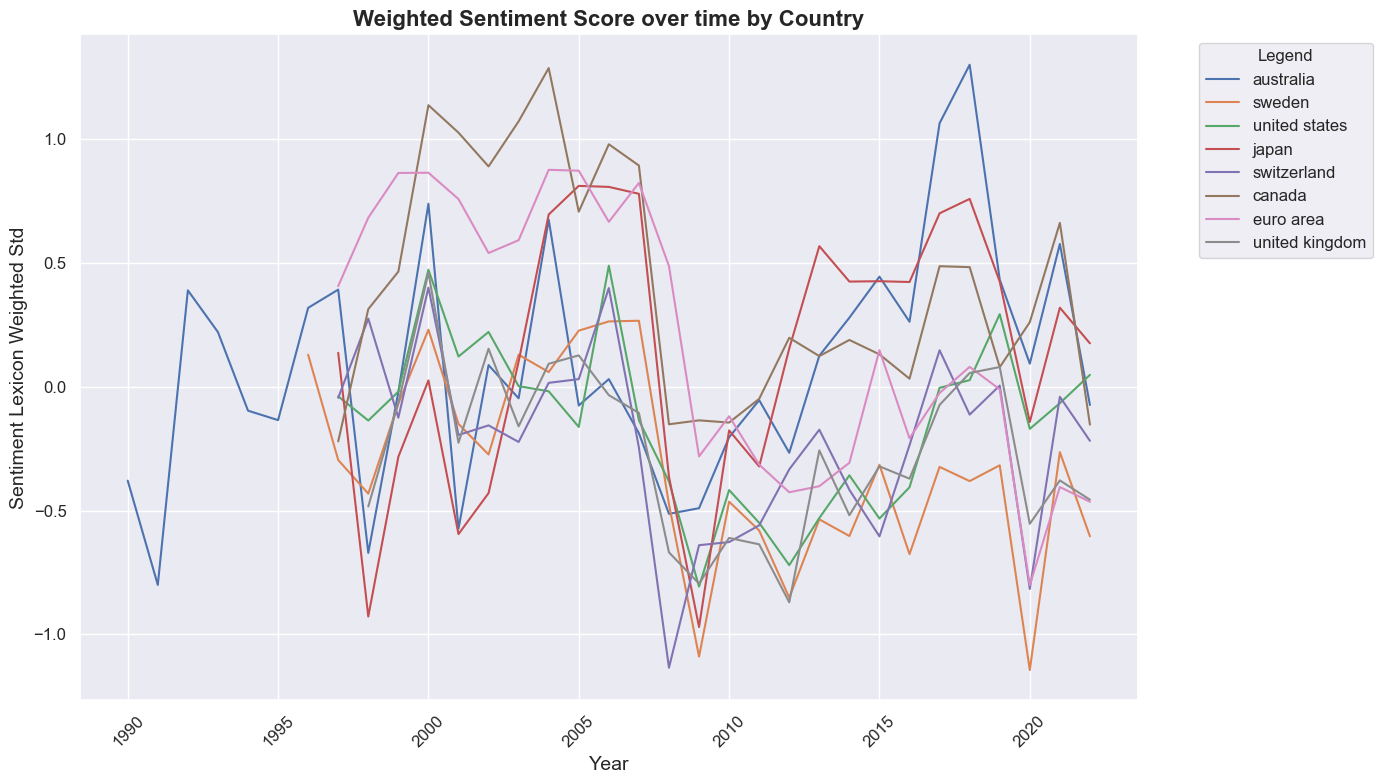

In [162]:
generate_multi_lineplot(speeches_yearly, x_axis='year', y_axis='sentiment_lexicon_weighted_std', hue='country', \
                        title= 'Weighted Sentiment Score over time by Country', date=None, ylim=None, \
                            save_path=None, errorbar=None, events=None)

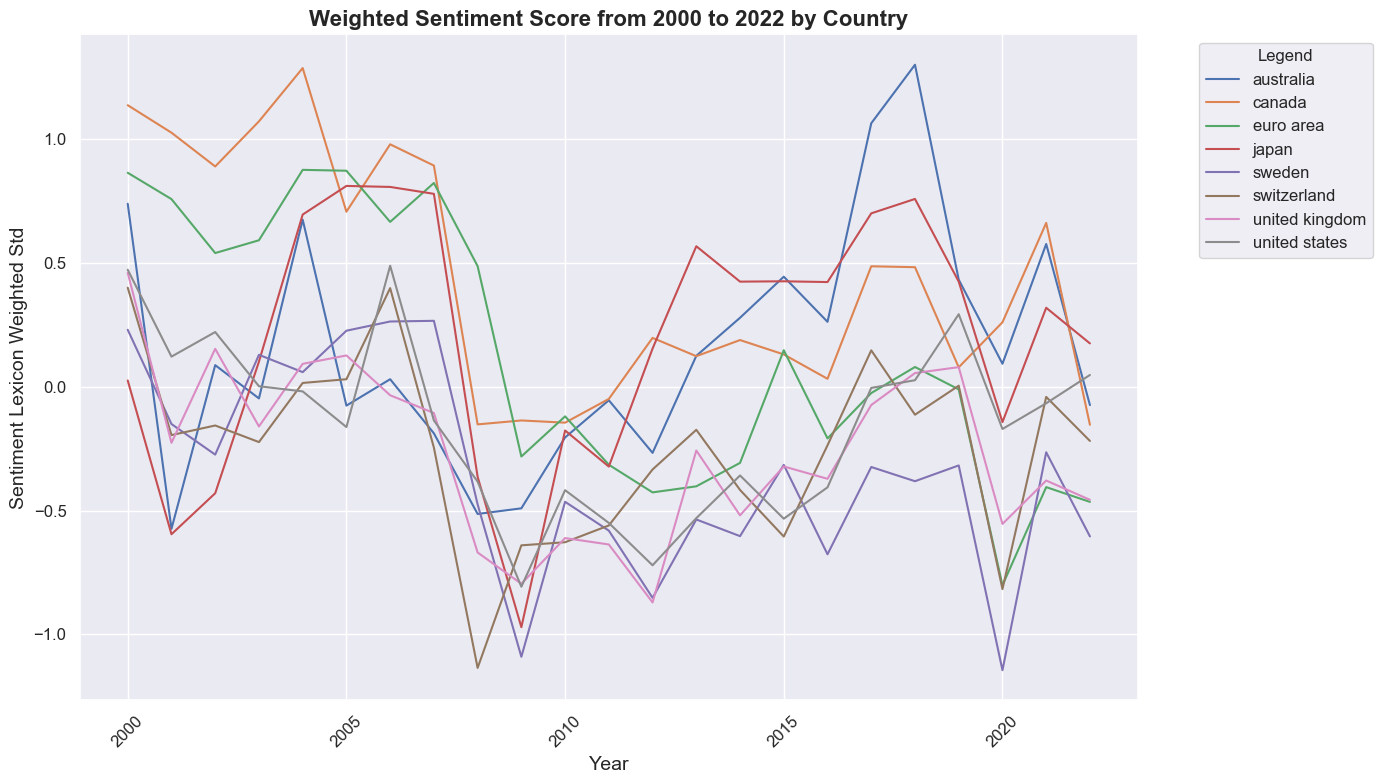

In [164]:
generate_multi_lineplot(speeches_yearly_filtered, x_axis='year', y_axis='sentiment_lexicon_weighted_std', hue='country', \
                        title= 'Weighted Sentiment Score from 2000 to 2022 by Country', date=None, ylim=None, \
                            save_path=None, errorbar=None, events=None)

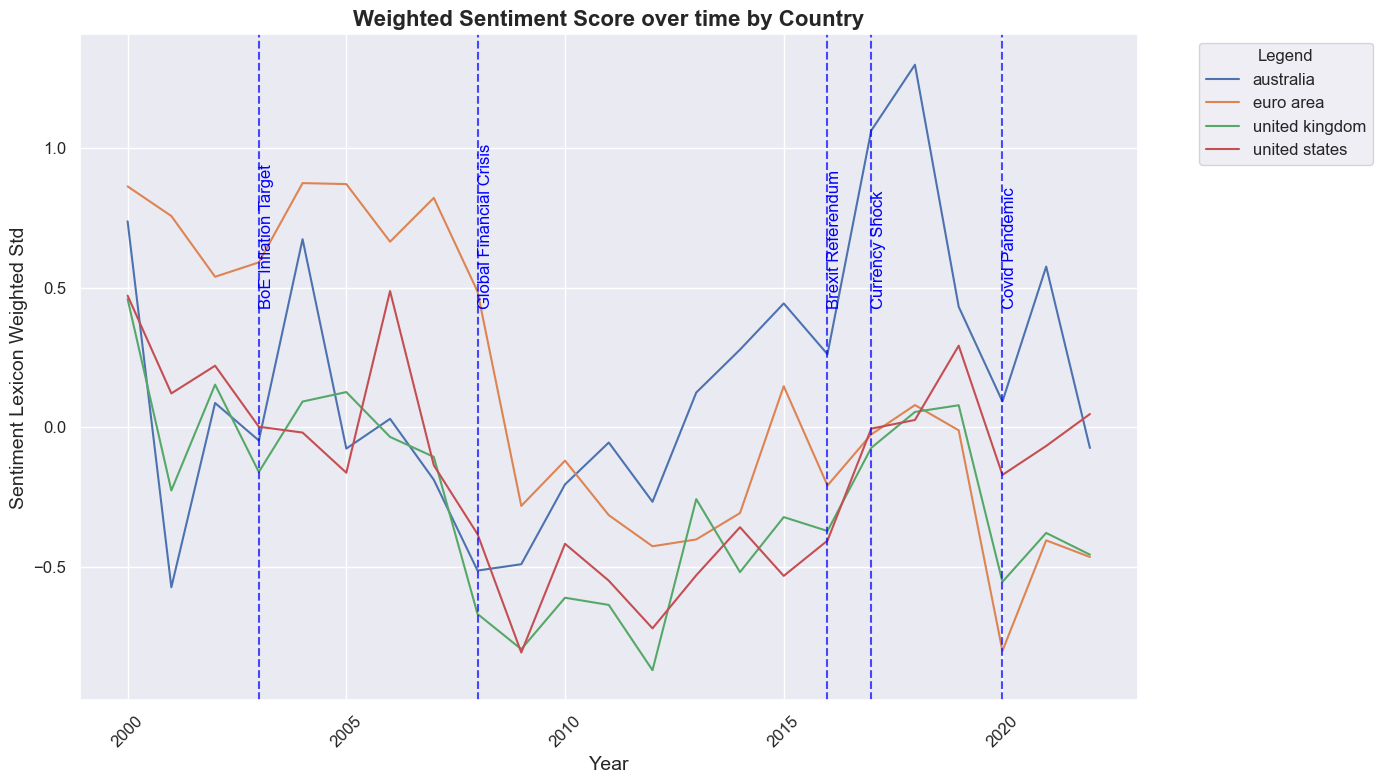

In [166]:
generate_multi_lineplot(speeches_yearly_filtered[speeches_yearly_filtered['country'].isin(countries_to_display)], \
                        x_axis='year', y_axis='sentiment_lexicon_weighted_std', hue='country', \
                        title= 'Weighted Sentiment Score over time by Country', date=None, ylim=None, \
                            save_path=None, errorbar=None, events=None, event_years=events)

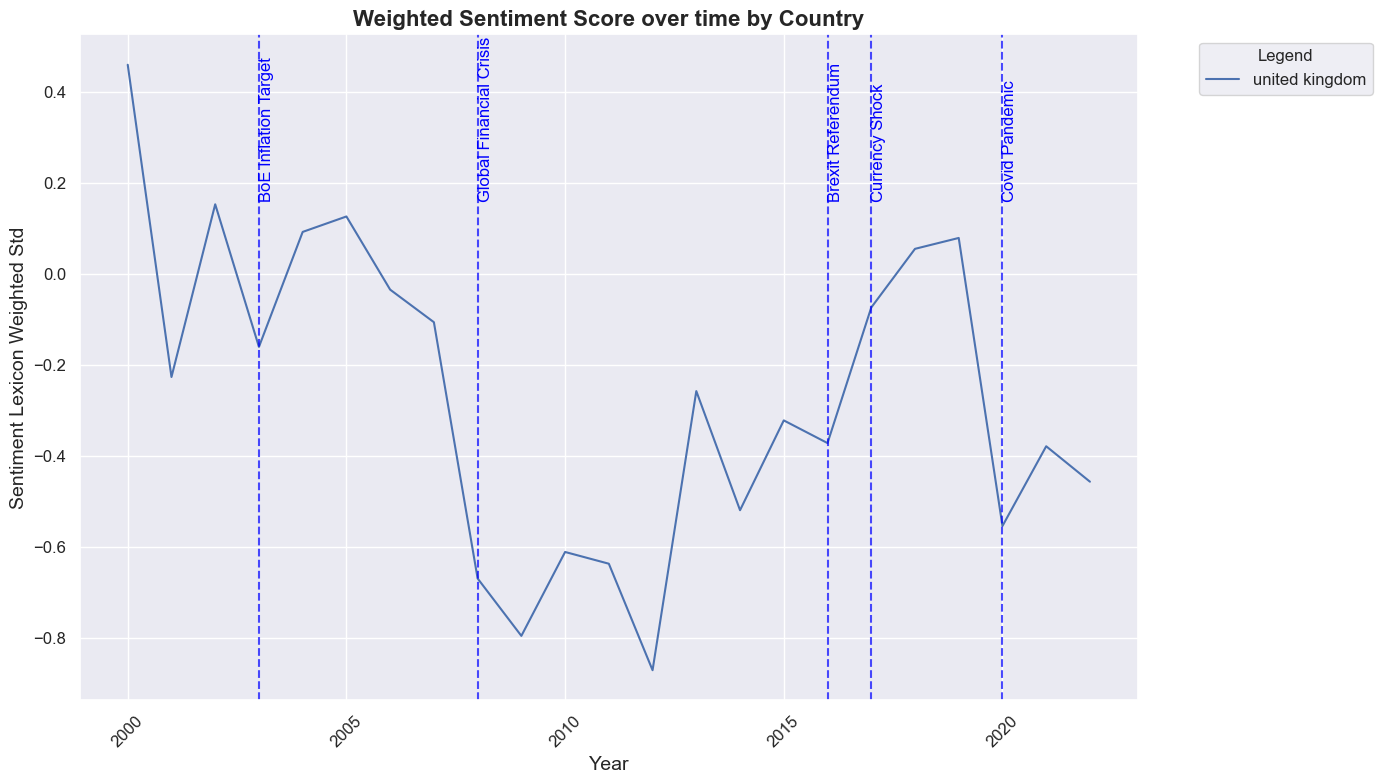

In [168]:
generate_multi_lineplot(speeches_yearly_filtered[speeches_yearly_filtered['country'].isin(country_to_display)], \
                        x_axis='year', y_axis='sentiment_lexicon_weighted_std', hue='country', \
                        title= 'Weighted Sentiment Score over time by Country', date=None, ylim=None, \
                            save_path=None, errorbar=None, events=None, event_years=events)

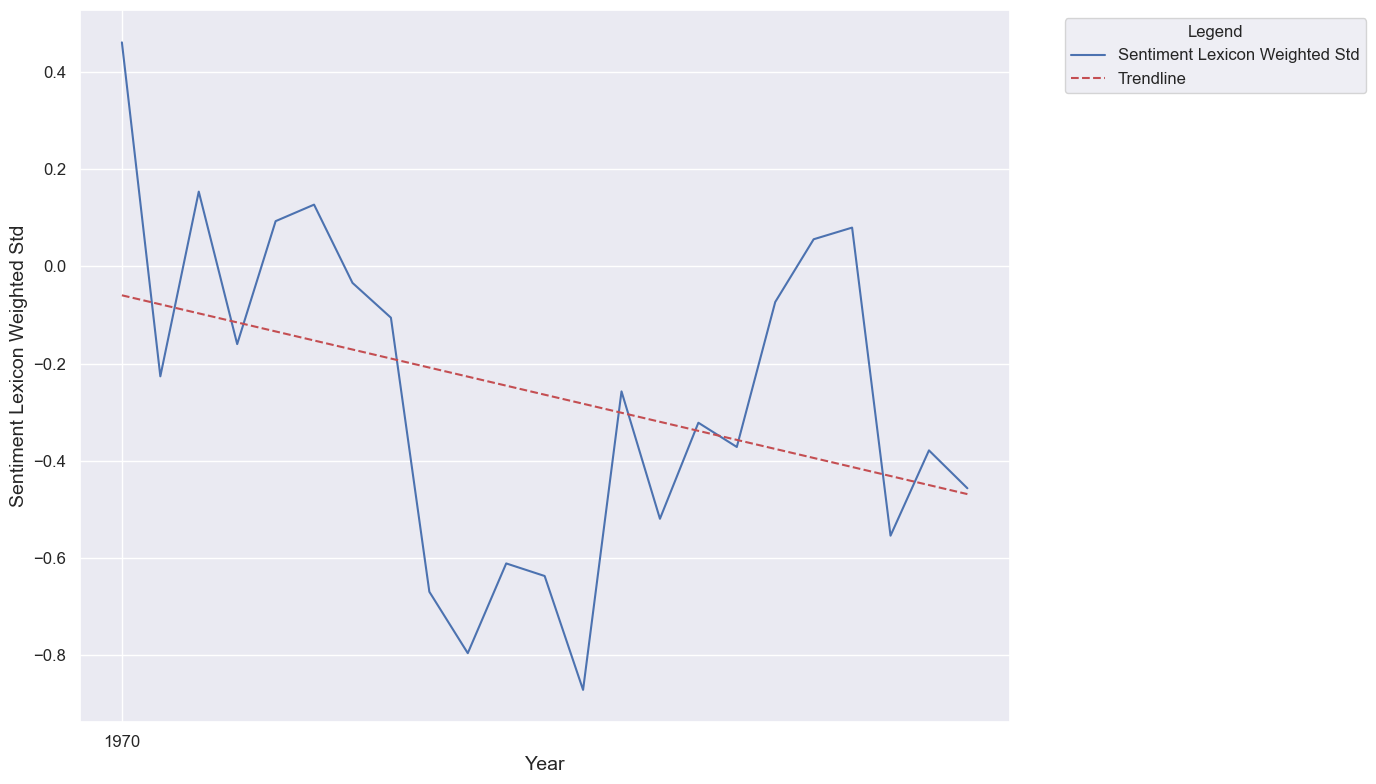

In [172]:
generate_lineplot_with_trendline(boe_speeches_yearly_filtered, x_axis='year', y_axis='sentiment_lexicon_weighted_std', \
                                 title=None, date=None, ylim=None, rotate_xticks=False, save_path=None, errorbar=None)

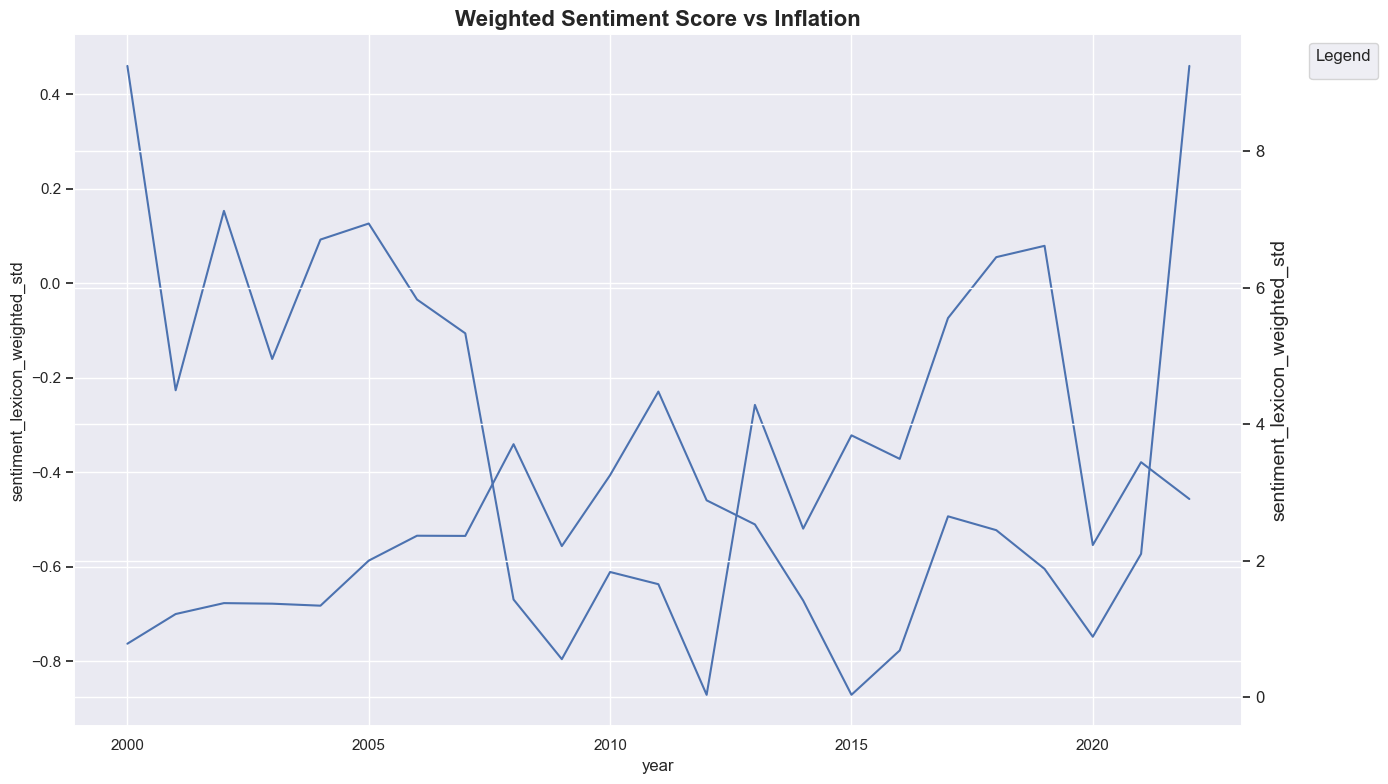

In [182]:
lineplot_two_axis(boe_speeches_yearly_filtered, x_axis='year', y_axis='sentiment_lexicon_weighted_std', hue=None, \
                  title='Weighted Sentiment Score vs Inflation', 
                    second_y='uk_inflation_rate_CPIH', second_y_label='UK Inflation',
                            date=None, ylim=None, save_path=None, 
                            errorbar=None, events=None, event_years=None)

### 3.2. View data in a wordclouds 

In [184]:
def show_wordcloud(counter):
    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counter)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_top_non_stopwords_wordcloud(text):
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    # Show the word cloud
    show_wordcloud(counter)

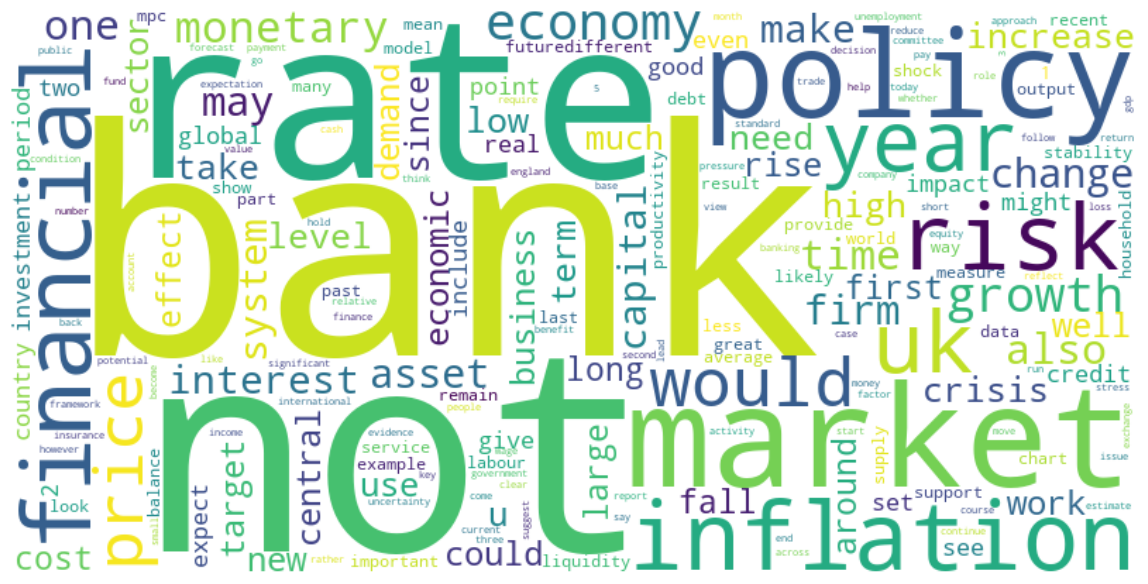

In [186]:
# Create wordcloud of lemmatised text
plot_top_non_stopwords_wordcloud(boe_speeches['text_lemmatised_str'])

In [188]:
# Define bar chart for top words
def top_words_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    # Set plot size
    plt.figure(figsize=(12, 8))
    
    # Plot
    sns.barplot(x=y, y=x)
    
    # Set label font sizes
    plt.xlabel('Count', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.title('Top Non-Stopword Words', fontsize=16)
    plt.tight_layout()
    plt.show()

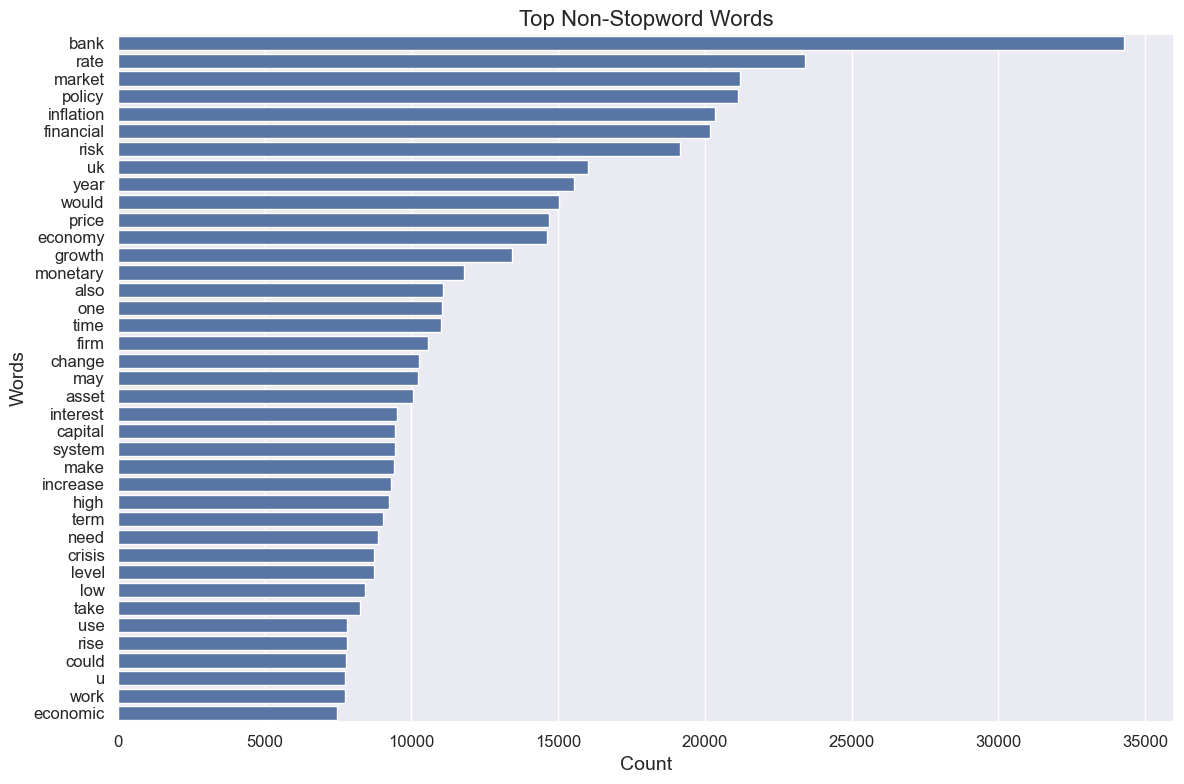

In [190]:
# Create bar chart to show top words
top_words_barchart(boe_speeches['text_lemmatised_str'])

In [192]:
# Define bar chart for top word groups
def top_word_group_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

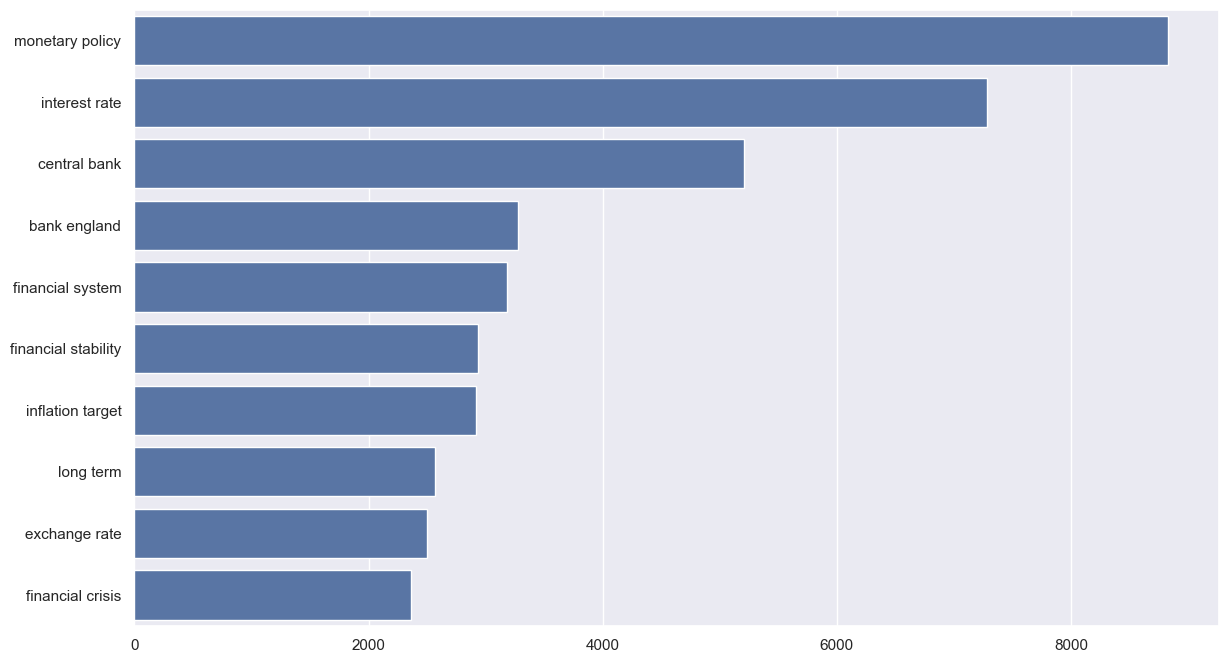

In [194]:
# Plot top phrases with 2 words
top_word_group_barchart(boe_speeches['text_lemmatised_str'],2)

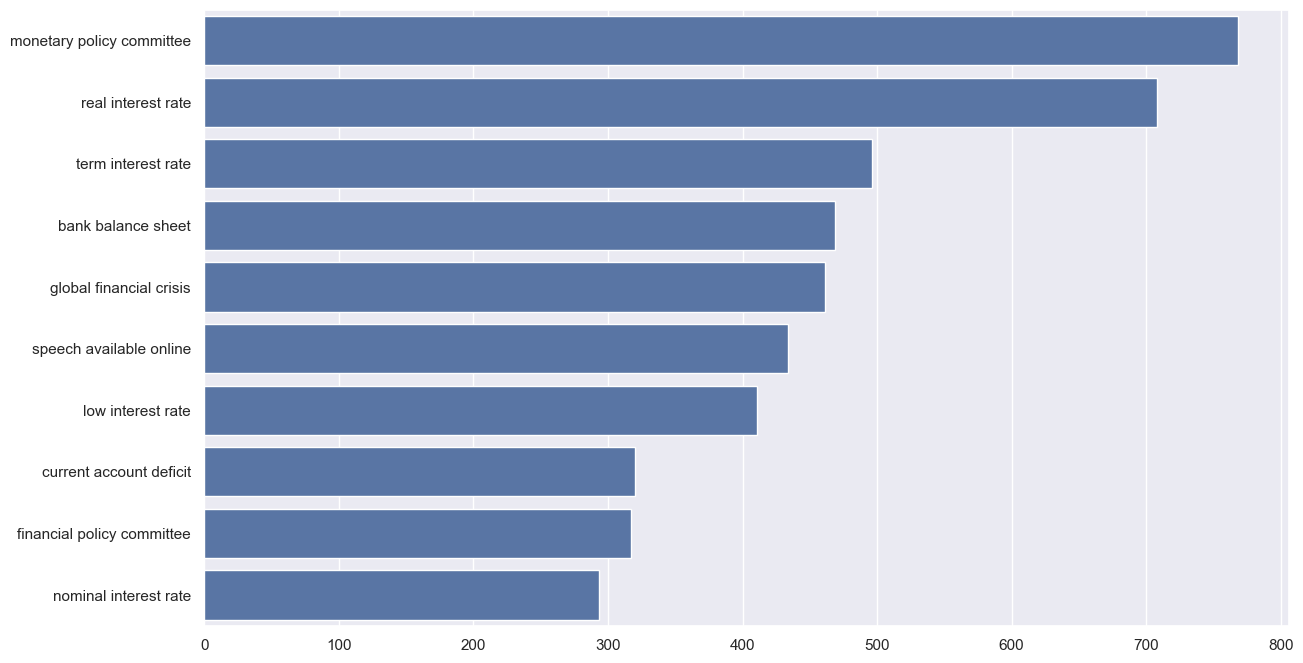

In [195]:
# Plot top phrases with 3 words
top_word_group_barchart(boe_speeches['text_lemmatised_str'],3)

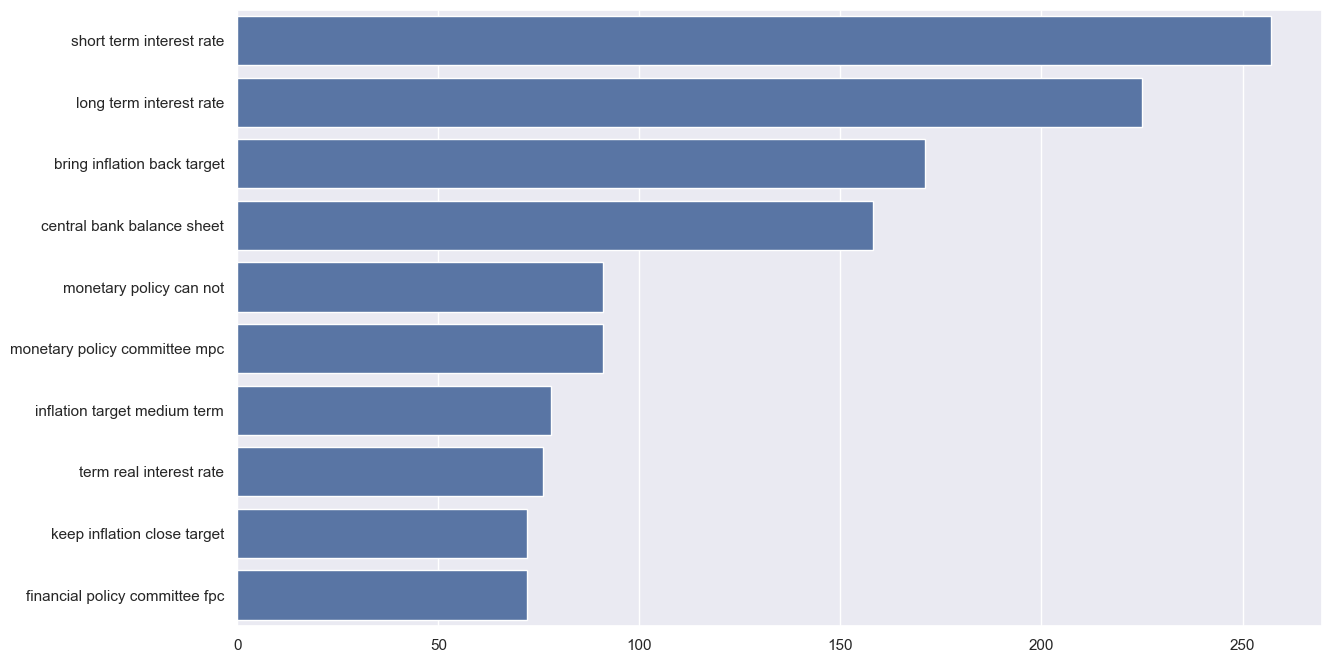

In [196]:
# Plot top phrases with 4 words
top_word_group_barchart(boe_speeches['text_lemmatised_str'],4)

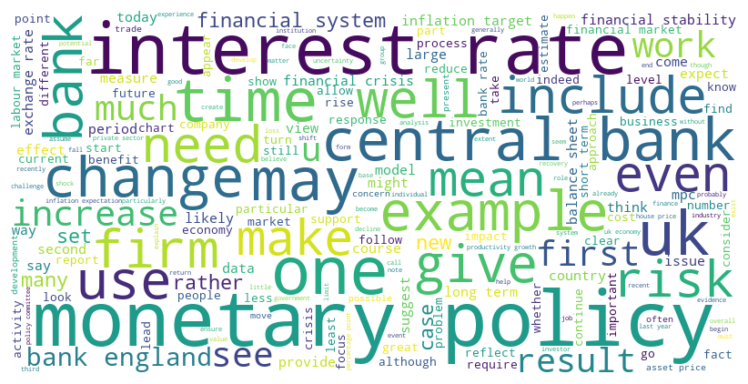

In [197]:
# Convert tokens into a single string.
boe_speeches_text = ' '.join(boe_speeches['text_lemmatised_str'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(boe_speeches_text)

# Display the word cloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')

# Hide the axis.
plt.axis('off') 

# Dispaly the word cloud.
plt.tight_layout()
plt.show()

## 4. Display the data

### Speech Statistics

**Word Count per Year**

In [224]:
# Group and aggregate sentiment scores by month
wordcount_monthly = boe_indicators_2000_2022.groupby('year_month_dt')[['word_count_text', 'word_count_text_cleaned']].mean().reset_index()

# View the DataFrame
wordcount_monthly.head()

,year_month_dt,word_count_text,word_count_text_cleaned
0,2000-01-01,3014.333333,1596.666667
1,2000-02-01,3714.200000,2026.000000
2,2000-03-01,3764.750000,2059.750000
3,2000-04-01,2749.666667,1502.000000
4,2000-05-01,3509.750000,1920.250000


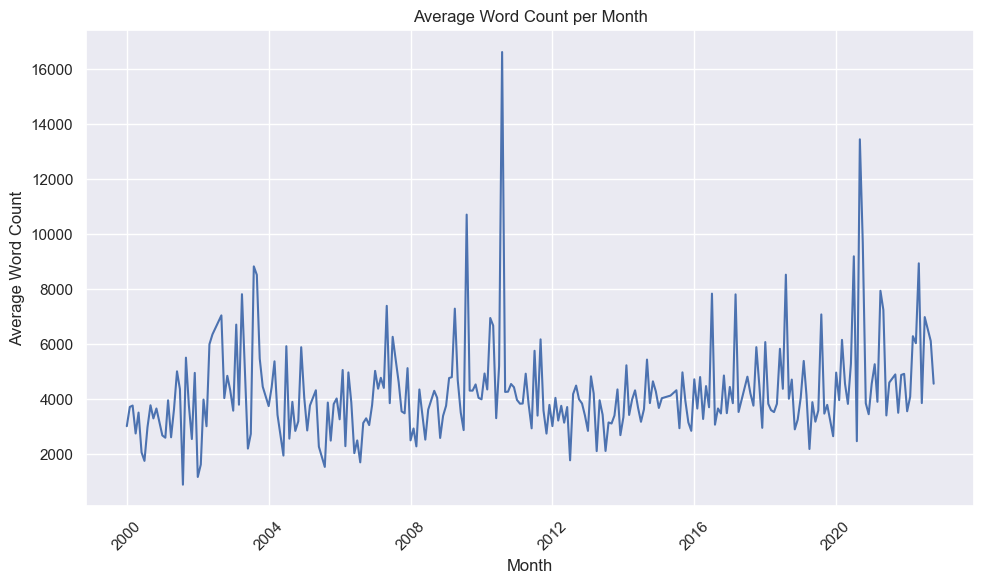

In [226]:
# Plot a line chart of average word count per month
plt.figure(figsize=(10, 6))
plt.plot(wordcount_monthly['year_month_dt'], wordcount_monthly['word_count_text'])
plt.xlabel('Month')
plt.ylabel('Average Word Count')
plt.title('Average Word Count per Month')
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [228]:
# Group and aggregate sentiment scores by year
wordcount_yearly = boe_indicators_2000_2022.groupby('year')[['word_count_text', 'word_count_text_cleaned']].mean().reset_index()

# View the DataFrame
wordcount_yearly.head()

,year,word_count_text,word_count_text_cleaned
0,2000,3168.472222,1707.055556
1,2001,3716.375000,2049.550000
2,2002,3996.500000,2184.500000
3,2003,4854.000000,2679.684211
4,2004,3948.000000,2174.642857


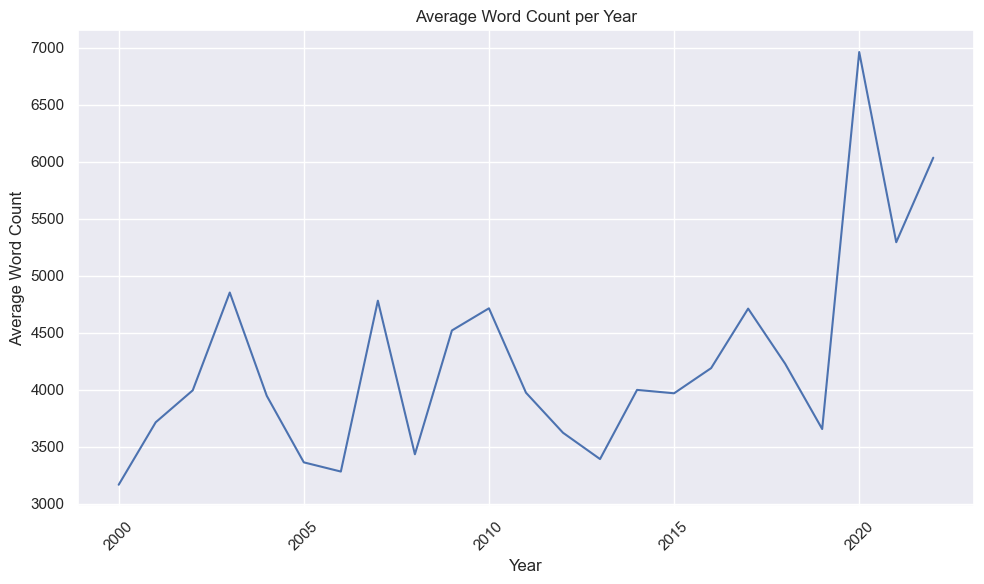

In [230]:
# Plot a line chart of average word count per year
plt.figure(figsize=(10, 6))
plt.plot(wordcount_yearly['year'], wordcount_yearly['word_count_text'])
plt.xlabel('Year')
plt.ylabel('Average Word Count')
plt.title('Average Word Count per Year')
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [234]:
# Group and aggregate sentiment scores by year
wordcount_count_yearly = boe_indicators_2000_2022.groupby('year').agg({'word_count_text': 'mean',
                                                                           'reference': 'count'
                                                                          }).reset_index().rename(columns={'reference': 'speech_count'})

# View the DataFrame
wordcount_count_yearly.head()

,year,word_count_text,speech_count
0,2000,3168.472222,36
1,2001,3716.375000,40
2,2002,3996.500000,30
3,2003,4854.000000,19
4,2004,3948.000000,28


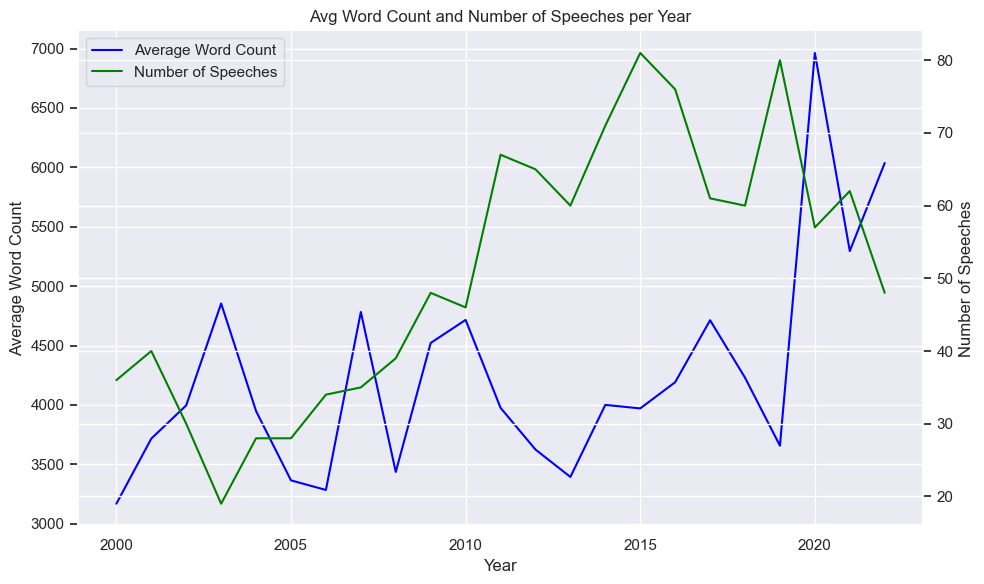

In [236]:
# Create the main plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 'word_count' on the primary y-axis
ax1.plot(wordcount_count_yearly['year'], wordcount_count_yearly['word_count_text'], color='blue', label='Average Word Count')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Word Count')
ax1.tick_params(axis='y')

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot 'speech_count' on the secondary y-axis
ax2.plot(wordcount_count_yearly['year'], wordcount_count_yearly['speech_count'], color='green', label='Number of Speeches')
ax2.set_ylabel('Number of Speeches')
ax2.tick_params(axis='y')

# Add titles and grid if needed
plt.title('Avg Word Count and Number of Speeches per Year')

# Optionally, add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Number of Speeches per Year**

In [238]:
# Group and aggregate number of speeches by governor by year
governor_speeches_monthly = boe_indicators_2000_2022.groupby(['year', 'is_gov']).size().reset_index(name='count')

# View the DataFrame
governor_speeches_monthly.head()

,year,is_gov,count
0,2000,0,19
1,2000,1,17
2,2001,0,27
3,2001,1,13
4,2002,0,14


In [240]:
# Pivot the data for plotting
governor_speeches_monthly_pivot = governor_speeches_monthly.pivot(index='year', columns='is_gov', values='count').fillna(0)

# View the DataFrame
governor_speeches_monthly_pivot.head()

is_gov,0,1
year,,
2000,19,17
2001,27,13
2002,14,16
2003,14,5
2004,20,8


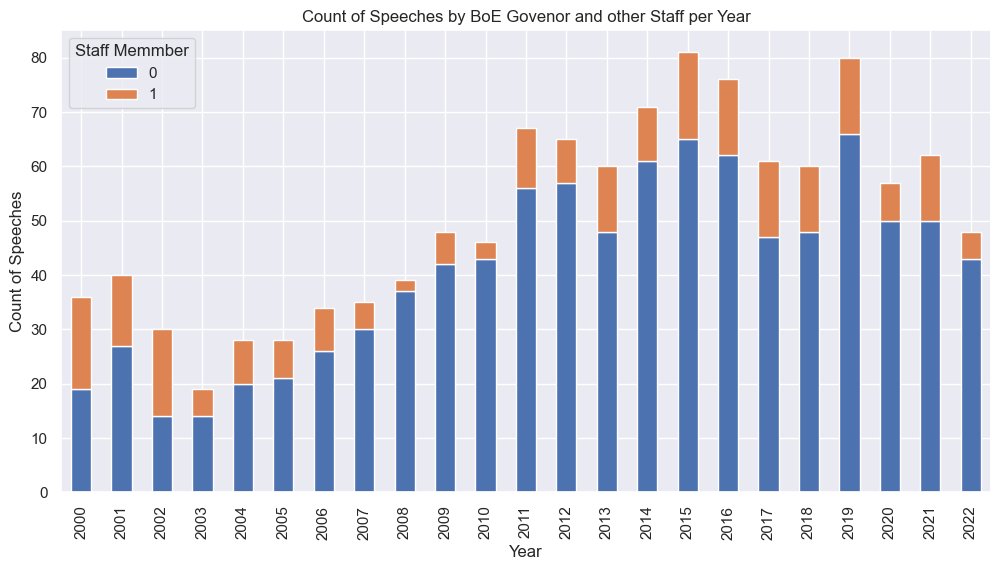

In [242]:
# Plot a bar chart per month
ax = governor_speeches_monthly_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize plot
ax.set_xlabel('Year')
ax.set_ylabel('Count of Speeches')
ax.set_title('Count of Speeches by BoE Govenor and other Staff per Year')
ax.legend(title='Staff Memmber')

# Display the plot
plt.show()

### 4.2.Seasonality Analysis

In [246]:
boe_indicators_2000_2022.columns

Index(['reference', 'country', 'date_format', 'year_month', 'year',
       'year_month_dt', 'title', 'author', 'is_gov', 'text', 'text_lemmatised',
       'text_lemmatised_str', 'word_count_text', 'word_count_text_cleaned',
       'sentiment_lexicon_simple', 'sentiment_lexicon_simple_std',
       'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std',
       'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth',
       'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx', 'ftse_250',
       'gilts_short ', 'gilts_medium ', 'gilts_long ',
       'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc',
       'avg_price_all_property_types'],
      dtype='object')

In [262]:
# Group and aggregate sentiment scores by month
sentiment_monthly = boe_indicators_2000_2022.groupby('year_month_dt')[['sentiment_lexicon_weighted_std']].mean().reset_index()

# View the DataFrame.
sentiment_monthly.head()

,year_month_dt,sentiment_lexicon_weighted_std
0,2000-01-01,0.128783
1,2000-02-01,0.509094
2,2000-03-01,0.680356
3,2000-04-01,-0.072648
4,2000-05-01,0.125045


In [258]:
# Set the datetime as index
sentiment_monthly.set_index('year_month_dt', inplace=True)

# View the DataFrame
sentiment_monthly

,sentiment_lexicon_weighted_std
year_month_dt,
2000-01-01,0.128783
2000-02-01,0.509094
2000-03-01,0.680356
2000-04-01,-0.072648
2000-05-01,0.125045
...,...
2022-05-01,-0.703591
2022-06-01,0.028070
2022-07-01,-0.470117


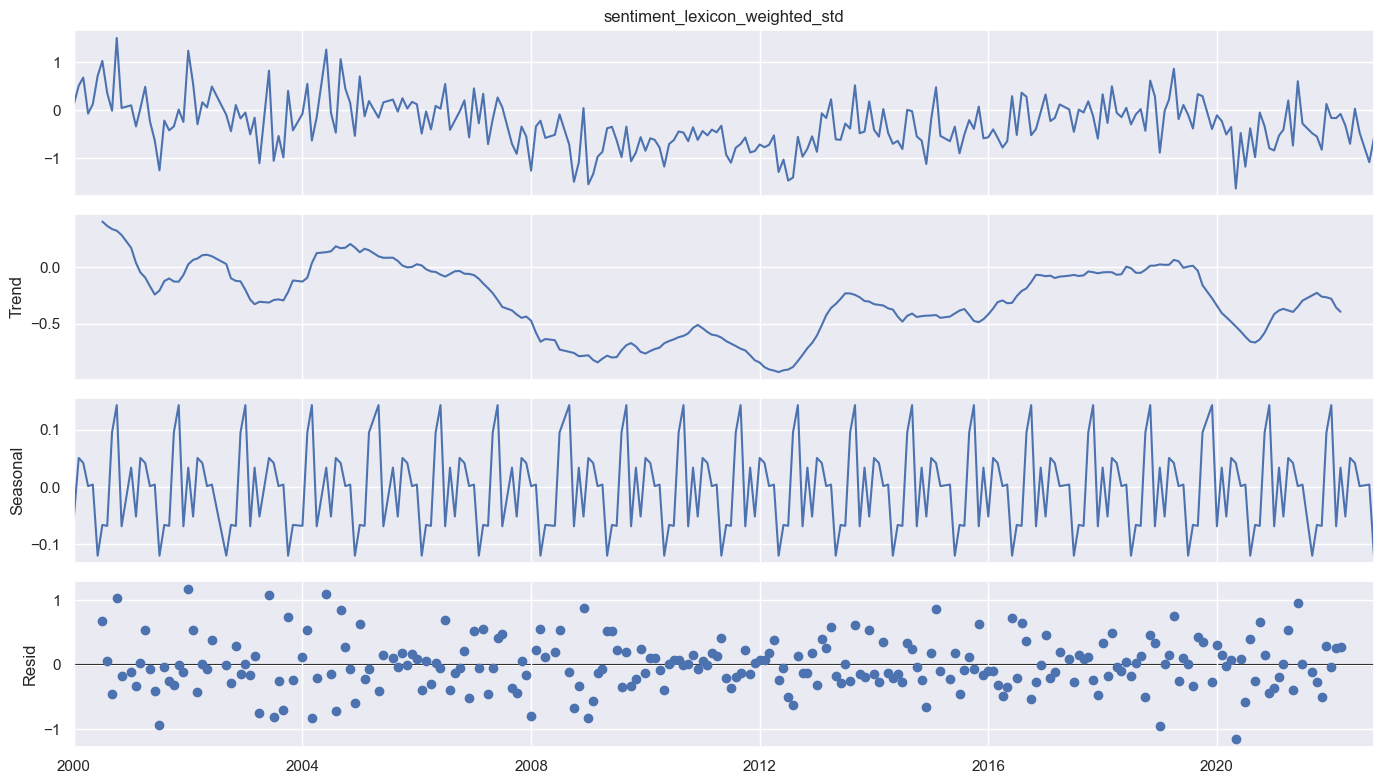

In [260]:
# Perform decomposition
decomposed_lexicon = seasonal_decompose(sentiment_monthly['sentiment_lexicon_weighted_std'], model='additive', period=12)

# Plot the decomposition
decomposed_lexicon.plot()
plt.show()

**Observations Peaks**
- August 2013: Peak with a speech announcing Jane Austen on 10 GBP note and a discussion of the evolution of monetary policy since 2008-2009 crisis
- January 2022: speech about inflation with a sense of urgency about controlling inflation with reassurance that the Bank is actively monitoring and prepared to act responsibly. 

In [310]:
# Copy the data to prepare it quarterly
sentiment_quarterly = sentiment_monthly.copy()

In [312]:
# Extract year and quarter
sentiment_quarterly['year'] = sentiment_quarterly['year_month_dt'].dt.year
sentiment_quarterly['quarter'] = sentiment_quarterly['year_month_dt'].dt.quarter

# Group by year and quarter
sentiment_quarterly = sentiment_quarterly.groupby(['year', 'quarter'])[['sentiment_lexicon_weighted_std']].mean().reset_index()

# Create a 'quarter_start' date if needed
sentiment_quarterly['quarter_start'] = pd.to_datetime(sentiment_quarterly['year'].astype(str) + 'Q' + sentiment_quarterly['quarter'].astype(str))

# View the DataFrame
sentiment_quarterly.head()

,year,quarter,sentiment_lexicon_weighted_std,quarter_start
0,2000,1,0.439411,2000-01-01
1,2000,2,0.255544,2000-04-01
2,2000,3,0.457944,2000-07-01
3,2000,4,0.776416,2000-10-01
4,2001,1,-0.067664,2001-01-01


In [314]:
# Set the datetime as index
sentiment_quarterly.set_index('quarter_start', inplace=True)

# View the DataFrame
sentiment_quarterly.head()

,year,quarter,sentiment_lexicon_weighted_std
quarter_start,,,
2000-01-01,2000,1,0.439411
2000-04-01,2000,2,0.255544
2000-07-01,2000,3,0.457944
2000-10-01,2000,4,0.776416
2001-01-01,2001,1,-0.067664


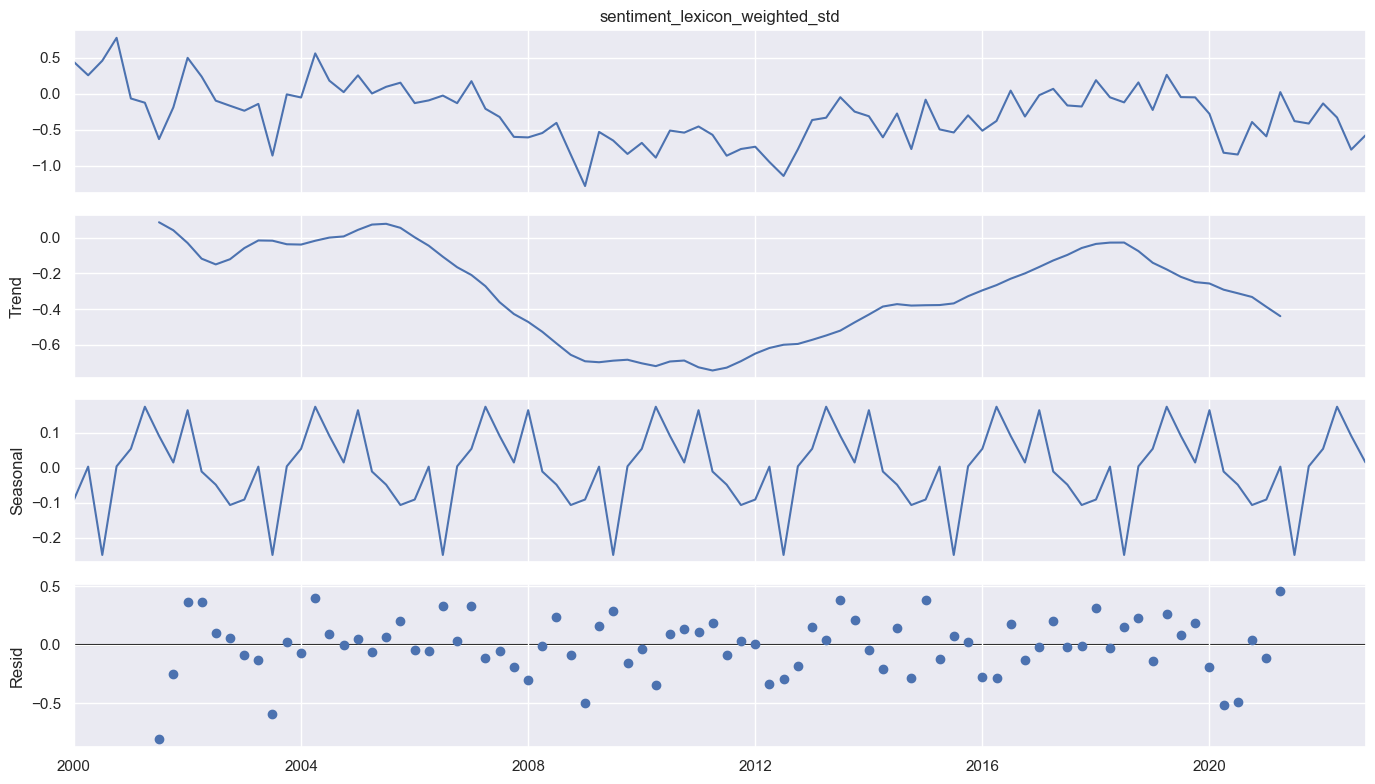

In [306]:
# Perform decomposition
decomposed_lexicon_quarterly = seasonal_decompose(sentiment_quarterly['sentiment_lexicon_weighted_std'], model='additive', period=12)

# Plot the decomposition
decomposed_lexicon_quarterly.plot()
plt.show()

In [318]:
# Group and aggregate sentiment scores by month
sentiment_quarterly_all = speeches_2000_2022.groupby(['year_month_dt', 'country'])[['sentiment_lexicon_weighted_std']].mean().reset_index()

# View the DataFrame.
sentiment_quarterly_all.head()

,year_month_dt,country,sentiment_lexicon_weighted_std
0,2000-01-01,canada,1.723085
1,2000-01-01,euro area,1.105004
2,2000-01-01,sweden,0.394178
3,2000-01-01,united kingdom,0.128783
4,2000-01-01,united states,-0.338708


## Governor speeches only

In [ ]:
# Filter speeches for governors only
boe_speeches_finbert_gov = boe_speeches_finbert[boe_speeches_finbert['is_gov'] == 1]

# View the DataFrame
boe_speeches_finbert_gov.head()

In [ ]:
# Review the DataFrame
boe_speeches_finbert_gov.info()

In [ ]:
# Group and aggregate sentiment scores by month
finbert_monthly_gov = boe_speeches_finbert_gov.groupby('year_month')[['yiyang_neutral', 'yiyang_positive', 'yiyang_negative', \
                                                              'yiyang_confidence', 'sentiment_score_yiyang', \
                                                                 'sentiment_score_yiyang_std']].mean().reset_index()
finbert_monthly_gov.head()

In [ ]:
# Change the date format
finbert_monthly_gov['year_month_dt'] = finbert_monthly_gov['year_month'].dt.to_timestamp()

In [ ]:
# Filter the data for 10 years
start_date = '2012-01'
end_date = '2022-12'

In [ ]:
# Filter the data for specified period
seasonality_finbert_gov_10 = finbert_monthly_gov[(finbert_monthly_gov['year_month'] >= start_date) & \
                          (finbert_monthly_gov['year_month'] <= end_date)]

In [ ]:
# Set the datetime as index
seasonality_finbert_gov_10.set_index('year_month_dt', inplace=True)

# View the DataFrame
seasonality_finbert_gov_10

In [ ]:
# Perform decomposition
decomposed = seasonal_decompose(seasonality_finbert_gov_10['sentiment_score_yiyang_std'], model='additive', period=12)

# Plot the decomposition
decomposed.plot()
plt.show()

### 4.1. Covid

In [ ]:
# Filter the data by date for Covid
start_date = '2020-01'
end_date = '2022-12'

In [ ]:
# Filter the data for specified period
finbert_covid = finbert_monthly[(finbert_monthly['year_month_dt'] >= start_date) & (finbert_monthly['year_month_dt'] <= end_date)]

In [ ]:
fig = px.line(
     finbert_covid,
     x='year_month_dt',
     y=['yiyang_neutral','yiyang_positive', 'yiyang_negative'],
     title='Average monthly Finbert scores – Bank of England speeches during Covid (2020–2022)',
     labels={'value': 'Average score', 'variable': 'Metric'},
    color_discrete_sequence=['blue', 'green', 'red']
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

In [ ]:
fig = px.line(
     finbert_covid,
     x='year_month_dt',
     y=['sentiment_score_yiyang_std'],
     title='Average monthly standardised Finbert scores – Bank of England speeches during Covid (2020–2022)',
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

In [ ]:
# Filter the data for specified period
finbert_gov_covid = finbert_monthly_gov[(finbert_monthly_gov['year_month_dt'] >= start_date) & (finbert_monthly_gov['year_month_dt'] <= end_date)]

In [ ]:
fig = px.line(
     finbert_gov_covid,
     x='year_month_dt',
     y=['yiyang_neutral','yiyang_positive', 'yiyang_negative'],
     title='Average monthly Finbert scores – Bank of England speeches during Covid (2020–2022)',
     labels={'value': 'Average score', 'variable': 'Metric'},
    color_discrete_sequence=['blue', 'green', 'red']
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

### 4.2. Brexit vote

In [ ]:
# Filter the data by date for before and after Brexit
start_date = '2016-01'
end_date = '2017-06'

In [ ]:
# Filter the data for specified period
finbert_brexit = finbert_monthly[(finbert_monthly['year_month_dt'] >= start_date) & (finbert_monthly['year_month_dt'] <= end_date)]

In [ ]:
fig = px.line(
     finbert_brexit,
     x='year_month_dt',
     y=['yiyang_neutral','yiyang_positive', 'yiyang_negative'],
     title='Average monthly Finbert scores – Bank of England speeches during Brexit (2016–2017)',
     labels={'value': 'Average score', 'variable': 'Metric'},
    color_discrete_sequence=['blue', 'green', 'red']
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

In [ ]:
fig = px.line(
     finbert_covid,
     x='year_month_dt',
     y=['sentiment_score_yiyang_std'],
     title='Average monthly stamdardised Finbert scores – Bank of England speeches during Brexit (2016–2017)',
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

### Filter the dataframe

In [ ]:
target_words = {
    'inflation': ['inflation'],           
    'monetary policy': ['monetary policy'],               
    'price stability': ['price stability'],
    'exchange rate': ['exchange rate'],
    'growth': ['growth'],
    'financial market': ['finanical market']
}

In [ ]:
def count_word(text, word):
    tokens = [w.lower() for w in word_tokenize(str(text))]
    return tokens.count(word.lower())

# Assuming your DataFrame is 'df' and text column is 'speech_text'

for category, words in target_words.items():
    # Since each category only has one word, no need to iterate over list, just take the first
    word = words[0]
    # Count occurrences of the word in each speech
    boe_speeches_sentiment[category + '_count'] = boe_speeches_sentiment['text_lemmatised'].apply(lambda x: count_word(x, word))

# Now, create separate dataframes per category
inflation_df = boe_speeches_sentiment[['text_lemmatised', 'inflation_count']].copy()
monetary_policy_df = boe_speeches_sentiment[['text_lemmatised', 'monetary policy_count']].copy()
price_stability_df = boe_speeches_sentiment[['text_lemmatised', 'price stability_count']].copy()
exchange_rate_df = boe_speeches_sentiment[['text_lemmatised', 'exchange rate_count']].copy()
growth_df = boe_speeches_sentiment[['text_lemmatised', 'growth_count']].copy()
financial_market_df = boe_speeches_sentiment[['text_lemmatised', 'financial market_count']].copy()

# (Optional) filter for speeches where the target word appears at least once
inflation_df = inflation_df[inflation_df['inflation_count'] > 3]
monetary_policy_df = monetary_policy_df[monetary_policy_df['monetary policy_count'] > 3]
price_stability_df = price_stability_df[price_stability_df['price stability_count'] > 3]
exchange_rate_df = exchange_rate_df[exchange_rate_df['exchange rate_count'] > 3]
growth_df = growth_df[growth_df['growth_count'] > 3]
financial_market_df = financial_market_df[financial_market_df['financial market_count'] > 3]

In [ ]:
def count_word(text, word):
    tokens = [w.lower() for w in word_tokenize(str(text))]
    return tokens.count(word.lower())

# Assuming your DataFrame is 'df' and text column is 'speech_text'

for category, words in target_words.items():
    # Since each category only has one word, no need to iterate over list, just take the first
    word = words[0]
    # Count occurrences of the word in each speech
    boe_speeches_sentiment[category + '_count'] = boe_speeches_sentiment['text'].apply(lambda x: count_word(x, word))

# Now, create separate dataframes per category
inflation_df = boe_speeches_sentiment[['text', 'inflation_count']].copy()
monetary_policy_df = boe_speeches_sentiment[['text', 'monetary policy_count']].copy()
price_stability_df = boe_speeches_sentiment[['text', 'price stability_count']].copy()
exchange_rate_df = boe_speeches_sentiment[['text', 'exchange rate_count']].copy()
growth_df = boe_speeches_sentiment[['text', 'growth_count']].copy()
financial_market_df = boe_speeches_sentiment[['text', 'financial market_count']].copy()

# (Optional) filter for speeches where the target word appears at least once
inflation_df = inflation_df[inflation_df['inflation_count'] > 3]
monetary_policy_df = monetary_policy_df[monetary_policy_df['monetary policy_count'] > 3]
price_stability_df = price_stability_df[price_stability_df['price stability_count'] > 3]
exchange_rate_df = exchange_rate_df[exchange_rate_df['exchange rate_count'] > 3]
growth_df = growth_df[growth_df['growth_count'] > 3]
financial_market_df = financial_market_df[financial_market_df['financial market_count'] > 3]

In [ ]:
inflation_df.head()

In [ ]:
monetary_policy_df.head()

In [ ]:
price_stability_df.head()

In [ ]:
exchange_rate_df.head()

In [ ]:
growth_df.head()

In [ ]:
financial_market_df.head()

In [ ]:
def count_target_words(text, target_words):
    tokens = [w.lower() for w in word_tokenize(str(text))]
    count = sum(tokens.count(word) for word in target_words)
    return count

# Apply and add as a new column
target_words = ['inflation', 'monetary policy', 'price stability', 'exchange rate', 'growth', 'financial market']
boe_speeches_sentiment['target_word_freq'] = boe_speeches_sentiment['text_lemmatised_str'].apply(lambda x: count_target_words(x, target_words))

# View the dataFrame
boe_speeches_sentiment.head()

In [ ]:
# For example, speeches where 'inflation' appears more than 3 times
inflation_df = boe_speeches_sentiment[boe_speeches_sentiment['target_word_freq'] > 5]

inflation_df.head()

## 4. Exploratory Analysis for Correlation with Economic Indicators

### 4.1. Prepare the data

In [ ]:
# List of DataFrames to merge
dataframes_to_merge = [uk_economic_indicators]

# Use reduce to merge all DataFrames in the list
boe_speeches_indicators = reduce(lambda left, right: left.merge(right, on='year_month', how='left'), dataframes_to_merge, boe_speeches_new)

# View the merged DataFrame
boe_speeches_indicators.head()

In [ ]:
# Check for missing values.
boe_speeches_indicators.isnull().sum()

In [ ]:
# Explore the DataFrame.
boe_speeches_indicators.info()

### 4.2. Plot the data

In [ ]:
# Display all column names.
boe_speeches_indicators.columns

In [ ]:
boe_speeches_indicators['year_month'].dtypes

In [ ]:
# Convert 'year_month' Period to datetime
# boe_speeches_indicators['date'] = boe_speeches_indicators['year_month'].dt.to_timestamp()

In [ ]:
# boe_speeches_indicators['year_month'].dtypes

**Confidence Index**

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['text_compound'], color='blue', label='VADER compound score')
ax1.set_xlabel('Date')
ax1.set_ylabel('VADER compound score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['confidence_index'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England VADER Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['sentiment_score_lm_weighted'], color='blue', label='sentiment_score_lm_weighted')
ax1.set_xlabel('Date')
ax1.set_ylabel('sentiment_score_lm_weighted', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['confidence_index'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators[['text_pos', 'text_neg', 'text_neu']], color='blue', label='VADER compound score')
ax1.set_xlabel('Date')
ax1.set_ylabel('VADER Scores', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['confidence_index'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England VADER Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators[['Positive', 'Negative', 'Uncertainty']], color='blue', label='Lexicom Sentiment')
ax1.set_xlabel('Date')
ax1.set_ylabel('Lexicon Sentiment', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['confidence_index'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England VADER Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

**Inflation**

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators[['negative_lm', 'positive_lm', 'uncertainty_lm']], color='blue', label='weighted_sentiment_LM')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Inflation Rate'], color='red', label='Inflation Rate')
ax2.set_ylabel('Inflation Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Inflation Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['sentiment_score_lm_weighted'], color='blue', label='sentiment_score_lm_weighted')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Unemployment rate'], color='red', label='Unemployment Rate')
ax2.set_ylabel('Unemployment Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Unemployment Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

**Interest Rates**

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['sentiment_score_lm_weighted'], color='blue', label='sentiment_score_lm_weighted')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Bank Rate'], color='red', label='Bank Rate')
ax2.set_ylabel('Bank Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Bank Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['sentiment_score_lm_weighted'], color='blue', label='sentiment_score_lm_weighted')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Bank Rate'], color='red', label='Bank Rate')
ax2.set_ylabel('Bank Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Bank Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators[['text_pos', 'text_neg', 'text_neu']], color='blue', label='VADER compound score')
ax1.set_xlabel('Date')
ax1.set_ylabel('VADER Scores', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Bank Rate'], color='red', label='Bank Rate')
ax2.set_ylabel('Bank Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England VADER Sentiment Score vs UK Bank Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

### 4.3. Initial statistical analysis

In [ ]:
boe_speeches_indicators.columns

**4.3.a. GPT Analysis**

In [ ]:
# Create a pairplot for GPT sentiment score and all economic indicators.
columns_sentiment_gpt = ['gpt_sentiment_std', 'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth',
                             'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx', 'ftse_250', 'gilts_short ', 
                             'gilts_medium ', 'gilts_long ', 'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc',
                             'avg_price_all_property_types']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_gpt], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Correlation matrix for GPT sentiment score with all economic indicators
correlation_matrix_gpt = boe_speeches_indicators[columns_sentiment_gpt].corr()

# Display the correlation matrix
correlation_matrix_gpt

In [ ]:
# Heatmap of the correlation matrix for GPT sentiment score with all economic indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_gpt, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of all Economic Indicators with GPT Sentiment')
plt.show()

In [ ]:
# Create a pairplot for GPT sentiment score and price/ inflation indicators
columns_sentiment_gpt_price = ['gpt_sentiment_std', 'uk_inflation_rate_CPIH', 'uk_interest_rate',
                             'avg_price_all_property_types']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_gpt_price], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Correlation matrix for GPT sentiment score with price/ inflation indicators
correlation_matrix_gpt_price = boe_speeches_indicators[columns_sentiment_gpt_price].corr()

# Display the correlation matrix
correlation_matrix_gpt_price

In [ ]:
# Heatmap of the correlation matrix with price/ inflation indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_gpt_price, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Price/Inflation Indicators with GPT Sentiment')
plt.show()

In [ ]:
# Create a pairplot for GPT sentiment score and macroeconnomic indicators
columns_sentiment_gpt_macro = ['gpt_sentiment_std', 'uk_gdp_growth', 'uk_unemployment_rate', 
                            'uk_credit_growth_no_cc', 'uk_consumer_confidence']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_gpt_macro], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout
plt.show()

In [ ]:
# Correlation matrix for GPT sentiment score with macroeconomic indicators
correlation_matrix_gpt_macro = boe_speeches_indicators[columns_sentiment_gpt_macro].corr()

# Display the correlation matrix
correlation_matrix_gpt_macro

In [ ]:
# Heatmap of the correlation matrix with macroeconomic indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_gpt_macro, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Macroeconomic Indicators with GPT Sentiment')
plt.show()

In [ ]:
# Create a pairplot for GPT sentiment score and financial indicators
columns_sentiment_gpt_finance = ['gpt_sentiment_std', 'gbp_usd_fx', 'ftse_250', 'gilts_short ', 
                             'gilts_medium ', 'gilts_long ']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_gpt_finance], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Correlation matrix for GPT sentiment score with financial indicators
correlation_matrix_gpt_finance = boe_speeches_indicators[columns_sentiment_gpt_finance].corr()

# Display the correlation matrix
correlation_matrix_gpt_finance

In [ ]:
# Heatmap of the correlation matrix with finance indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_gpt_finance, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Financial Indicators with GPT Sentiment')
plt.show()

In [ ]:
# Create a pairplot for GPT sentiment score and most impactful indicators
columns_sentiment_gpt_top = ['gpt_sentiment_std', 'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 
                            'uk_credit_growth_no_cc', 'uk_consumer_confidence', 'ftse_250']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_gpt_top], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Correlation matrix for GPT sentiment score with and most impactful indicators
correlation_matrix_gpt_top = boe_speeches_indicators[columns_sentiment_gpt_top].corr()

# Display the correlation matrix
correlation_matrix_gpt_top

In [ ]:
# Heatmap of the correlation matrix with most impactful indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_gpt_top, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Most Impactful Indicators with GPT Sentiment')
plt.show()

**4.3.c. FinBert Analysis**

In [ ]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_sentiment_finbert = ['sentiment_score_yiyang_std', 'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth',
                             'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx', 'ftse_250', 'gilts_short ', 
                             'gilts_medium ', 'gilts_long ', 'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc',
                             'avg_price_all_property_types']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_finbert], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_finbert = boe_speeches_indicators[columns_sentiment_finbert].corr()

# Display the correlation matrix
correlation_matrix_finbert

In [ ]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_finbert, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Economic Indicators')
plt.show()

In [ ]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_sentiment_finbert_inflation = ['sentiment_score_yiyang_std', 'uk_inflation_rate_CPIH', 'uk_interest_rate',
                             'avg_price_all_property_types']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_finbert_inflation], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_finbert_inflation = boe_speeches_indicators[columns_sentiment_finbert_inflation].corr()

# Display the correlation matrix
correlation_matrix_finbert_inflation

In [ ]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_finbert_inflation, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Economic Indicators on Price & Inflation')
plt.show()

In [ ]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_sentiment_finbert_macro = ['sentiment_score_yiyang_std', 'uk_gdp_growth', 'uk_unemployment_rate', 
                            'uk_credit_growth_no_cc', 'uk_consumer_confidence']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_finbert_macro], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout
plt.show()

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_finbert_macro = boe_speeches_indicators[columns_sentiment_finbert_macro].corr()

# Display the correlation matrix
correlation_matrix_finbert_macro

In [ ]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_finbert_macro, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Macroeconomic Indicators ')
plt.show()

In [ ]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_sentiment_finbert_finance = ['sentiment_score_yiyang_std', 'gbp_usd_fx', 'ftse_250', 'gilts_short ', 
                             'gilts_medium ', 'gilts_long ']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_finbert_finance], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_finbert_finance = boe_speeches_indicators[columns_sentiment_finbert_finance].corr()

# Display the correlation matrix
correlation_matrix_finbert_finance

## 5. Random Forests

In [ ]:
# List of DataFrames to merge
dataframes_to_merge = [uk_economic_indicators]

# Use reduce to merge all DataFrames in the list
boe_speeches_indicators = reduce(lambda left, right: left.merge(right, on='year_month', how='left'), dataframes_to_merge, boe_speeches_new)

# View the merged DataFrame
boe_speeches_indicators.head()

In [ ]:
boe_speeches_indicators.columns

In [ ]:
boe_speeches_indicators['date_format'].dtypes

In [ ]:
# Copy the DataFranme for further manipulation
boe_rf = boe_speeches_indicators.copy()

In [ ]:
# Step 1: Convert 'date' to datetime if it's not already
boe_rf['date_time'] = pd.to_datetime(boe_rf['date'])

In [ ]:
# Set 'date' as index for resampling
boe_rf.set_index('date_time', inplace=True)

In [ ]:
# View the DataFrame
boe_rf.head()

### 5.1. Monthly Analysis with BoE Wordlist Sentiment Score

In [ ]:
# Aggregate sentiment scores and consumer confidence monthly
boe_rf_monthly = boe_rf.resample('M').agg({
            'sentiment_score_lexicon_std': 'mean',
            'gpt_sentiment_std': 'mean',
            'uk_consumer_confidence': 'mean',
            'uk_inflation_rate_CPIH': 'mean',
            'uk_unemployment_rate': 'mean',
            'uk_gdp_growth': 'mean',
            'uk_interest_rate': 'mean',
            'uk_consumer_confidence': 'mean', 
            'gbp_usd_fx': 'mean',
            'ftse_250': 'mean',
            'gilts_short ': 'mean',
            'gilts_medium ': 'mean', 
            'gilts_long ': 'mean', 
            'uk_credit_growth_no_cc': 'mean',
            'uk_credit_growth_only_cc': 'mean',
            'avg_price_all_property_types': 'mean'
})

# Reset index to turn 'date' back into a column
boe_rf_monthly.reset_index(inplace=True)

In [ ]:
# View the DataFrame
boe_rf_monthly.head()

In [ ]:
# Create date-related features
boe_rf_monthly['month'] = boe_rf_monthly['date_time'].dt.month
boe_rf_monthly['quarter'] = boe_rf_monthly['date_time'].dt.quarter
boe_rf_monthly['year'] = boe_rf_monthly['date_time'].dt.year

In [ ]:
# View the DataFrame
boe_rf_monthly.head()

In [ ]:
# Create lagged feature for sentiment score with 1 month lag
boe_rf_monthly['sentiment_score_lexicon_std_lag_1m'] = boe_rf_monthly['sentiment_score_lexicon_std'].shift(1)

In [ ]:
# Create lagged feature for sentiment score with 1 month lag
boe_rf_monthly['sentiment_score_lexicon_std_lag_3m'] = boe_rf_monthly['sentiment_score_lexicon_std'].shift(3)

In [ ]:
# View the DataFrame
boe_rf_monthly.head()

In [ ]:
# Drop first row(s) with NaN values due to lagging
boe_rf_monthly.dropna(inplace=True)

In [ ]:
# Prepare features (X)
feature_cols = ['sentiment_score_lexicon_std', 'sentiment_score_lexicon_std_lag_1m', 'sentiment_score_lexicon_std_lag_3m', 'month', 'quarter', 'year']
X = boe_rf_monthly[feature_cols]

# For each indicator (target)
for target in ['uk_consumer_confidence',
            'uk_inflation_rate_CPIH',
            'uk_unemployment_rate',
            'uk_gdp_growth',
            'uk_interest_rate',
            'uk_consumer_confidence', 
            'gbp_usd_fx',
            'ftse_250',
            'gilts_short ',
            'gilts_medium ', 
            'gilts_long ', 
            'uk_credit_growth_no_cc',
            'uk_credit_growth_only_cc',
            'avg_price_all_property_types']:
            y = boe_rf_monthly[target]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# List of targets
targets = [
    'uk_consumer_confidence',
    'uk_inflation_rate_CPIH',
    'uk_unemployment_rate',
    'uk_gdp_growth',
    'uk_interest_rate',
    'uk_consumer_confidence', 
    'gbp_usd_fx',
    'ftse_250',
    'gilts_short ',
    'gilts_medium ', 
    'gilts_long ', 
    'uk_credit_growth_no_cc',
    'uk_credit_growth_only_cc',
    'avg_price_all_property_types'
]

# Features
feature_cols = [
    'sentiment_score_lexicon_std', 
    'sentiment_score_lexicon_std_lag_1m',
    'sentiment_score_lexicon_std_lag_3m',
    'month', 'quarter', 'year'
]

# Loop through each target
for target in targets:
    print(f"\nTraining model for: {target}")
    y = boe_rf_monthly[target]
    X = boe_rf_monthly[feature_cols]

    # Time-series aware split without shuffling
    split_idx = int(len(boe_rf_monthly) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")

### 5.2. Quarterly Analysis woth BoE Wordlist Sentiment Score

In [ ]:
# Aggregate sentiment scores and consumer confidence monthly
boe_rf_quarterly = boe_rf.resample('Q').agg({
            'sentiment_score_lexicon_std': 'mean',
            'gpt_sentiment_std': 'mean',
            'uk_consumer_confidence': 'mean',
            'uk_inflation_rate_CPIH': 'mean',
            'uk_unemployment_rate': 'mean',
            'uk_gdp_growth': 'mean',
            'uk_interest_rate': 'mean',
            'uk_consumer_confidence': 'mean', 
            'gbp_usd_fx': 'mean',
            'ftse_250': 'mean',
            'gilts_short ': 'mean',
            'gilts_medium ': 'mean', 
            'gilts_long ': 'mean', 
            'uk_credit_growth_no_cc': 'mean',
            'uk_credit_growth_only_cc': 'mean',
            'avg_price_all_property_types': 'mean'
})

# Reset index to turn 'date' back into a column
boe_rf_quarterly.reset_index(inplace=True)

In [ ]:
# Create date-related features
boe_rf_quarterly['month'] = boe_rf_quarterly['date_time'].dt.month
boe_rf_quarterly['quarter'] = boe_rf_quarterly['date_time'].dt.quarter
boe_rf_quarterly['year'] = boe_rf_quarterly['date_time'].dt.year

In [ ]:
# Create lagged features (3 months lag is now 1 quarter lag)
boe_rf_quarterly['sentiment_score_lexicon_std_lag_1q'] = boe_rf_quarterly['sentiment_score_lexicon_std'].shift(1)

In [ ]:
# View the DataFrame
boe_rf_quarterly.head()

In [ ]:
# Drop NaNs due to lag
boe_rf_quarterly.dropna(inplace=True)

In [ ]:
# Prepare features (X)
feature_cols = ['sentiment_score_lexicon_std', 'sentiment_score_lexicon_std_lag_1q', 'month', 'quarter', 'year']
X = boe_rf_quarterly[feature_cols]

# For each indicator (target)
for target in ['uk_consumer_confidence',
            'uk_inflation_rate_CPIH',
            'uk_unemployment_rate',
            'uk_gdp_growth',
            'uk_interest_rate',
            'uk_consumer_confidence', 
            'gbp_usd_fx',
            'ftse_250',
            'gilts_short ',
            'gilts_medium ', 
            'gilts_long ', 
            'uk_credit_growth_no_cc',
            'uk_credit_growth_only_cc',
            'avg_price_all_property_types']:
            y = boe_rf_quarterly[target]

In [ ]:
# List of targets
targets = [
    'uk_consumer_confidence',
    'uk_inflation_rate_CPIH',
    'uk_unemployment_rate',
    'uk_gdp_growth',
    'uk_interest_rate',
    'uk_consumer_confidence', 
    'gbp_usd_fx',
    'ftse_250',
    'gilts_short ',
    'gilts_medium ', 
    'gilts_long ', 
    'uk_credit_growth_no_cc',
    'uk_credit_growth_only_cc',
    'avg_price_all_property_types'
]

# Features
feature_cols = [
    'sentiment_score_lexicon_std', 
    'sentiment_score_lexicon_std_lag_1q',
    'month', 'quarter', 'year'
]

# Loop through each target
for target in targets:
    print(f"\nTraining model for: {target}")
    y = boe_rf_quarterly[target]
    X = boe_rf_quarterly[feature_cols]

    # Time-series aware split without shuffling
    split_idx = int(len(boe_rf_quarterly) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")

### 5.3. Monthly Analysis with GPT Sentiment Score

In [ ]:
# Aggregate sentiment scores and consumer confidence monthly
boe_rf_monthly_gpt = boe_rf.resample('M').agg({
            'gpt_sentiment_std': 'mean',
            'gpt_sentiment_std': 'mean',
            'uk_consumer_confidence': 'mean',
            'uk_inflation_rate_CPIH': 'mean',
            'uk_unemployment_rate': 'mean',
            'uk_gdp_growth': 'mean',
            'uk_interest_rate': 'mean',
            'uk_consumer_confidence': 'mean', 
            'gbp_usd_fx': 'mean',
            'ftse_250': 'mean',
            'gilts_short ': 'mean',
            'gilts_medium ': 'mean', 
            'gilts_long ': 'mean', 
            'uk_credit_growth_no_cc': 'mean',
            'uk_credit_growth_only_cc': 'mean',
            'avg_price_all_property_types': 'mean'
})

# Reset index to turn 'date' back into a column
boe_rf_monthly_gpt.reset_index(inplace=True)

In [ ]:
# View the DataFrame
boe_rf_monthly_gpt.head()

In [ ]:
# Create date-related features
boe_rf_monthly_gpt['month'] = boe_rf_monthly_gpt['date_time'].dt.month
boe_rf_monthly_gpt['quarter'] = boe_rf_monthly_gpt['date_time'].dt.quarter
boe_rf_monthly_gpt['year'] = boe_rf_monthly_gpt['date_time'].dt.year

In [ ]:
# View the DataFrame
boe_rf_monthly_gpt.head()

In [ ]:
# Create lagged feature for sentiment score with 1 month lag
boe_rf_monthly_gpt['gpt_sentiment_std_lag_1m'] = boe_rf_monthly_gpt['gpt_sentiment_std'].shift(1)

In [ ]:
# Create lagged feature for sentiment score with 1 month lag
boe_rf_monthly_gpt['gpt_sentiment_std_lag_3m'] = boe_rf_monthly_gpt['gpt_sentiment_std'].shift(3)

In [ ]:
# View the DataFrame
boe_rf_monthly_gpt.head()

In [ ]:
# Drop first row(s) with NaN values due to lagging
boe_rf_monthly_gpt.dropna(inplace=True)

In [ ]:
# Prepare features (X)
feature_cols = ['gpt_sentiment_std', 'gpt_sentiment_std_lag_1m', 'gpt_sentiment_std_lag_3m', 'month', 'quarter', 'year']
X = boe_rf_monthly_gpt[feature_cols]

# For each indicator (target)
for target in ['uk_consumer_confidence',
            'uk_inflation_rate_CPIH',
            'uk_unemployment_rate',
            'uk_gdp_growth',
            'uk_interest_rate',
            'uk_consumer_confidence', 
            'gbp_usd_fx',
            'ftse_250',
            'gilts_short ',
            'gilts_medium ', 
            'gilts_long ', 
            'uk_credit_growth_no_cc',
            'uk_credit_growth_only_cc',
            'avg_price_all_property_types']:
            y = boe_rf_monthly_gpt[target]

In [ ]:
# List of targets
targets = [
    'uk_consumer_confidence',
    'uk_inflation_rate_CPIH',
    'uk_unemployment_rate',
    'uk_gdp_growth',
    'uk_interest_rate',
    'uk_consumer_confidence', 
    'gbp_usd_fx',
    'ftse_250',
    'gilts_short ',
    'gilts_medium ', 
    'gilts_long ', 
    'uk_credit_growth_no_cc',
    'uk_credit_growth_only_cc',
    'avg_price_all_property_types'
]

# Features
feature_cols = [
    'gpt_sentiment_std', 
    'gpt_sentiment_std_lag_1m',
    'gpt_sentiment_std_lag_3m',
    'month', 'quarter', 'year'
]

# Loop through each target
for target in targets:
    print(f"\nTraining model for: {target}")
    y = boe_rf_monthly_gpt[target]
    X = boe_rf_monthly_gpt[feature_cols]

    # Time-series aware split without shuffling
    split_idx = int(len(boe_rf_monthly_gpt) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")

### 5.2. Quarterly Analysis woth BoE Wordlist Sentiment Score

In [ ]:
# Aggregate sentiment scores and consumer confidence monthly
boe_rf_quarterly_gpt = boe_rf.resample('Q').agg({
            'gpt_sentiment_std': 'mean',
            'gpt_sentiment_std': 'mean',
            'uk_consumer_confidence': 'mean',
            'uk_inflation_rate_CPIH': 'mean',
            'uk_unemployment_rate': 'mean',
            'uk_gdp_growth': 'mean',
            'uk_interest_rate': 'mean',
            'uk_consumer_confidence': 'mean', 
            'gbp_usd_fx': 'mean',
            'ftse_250': 'mean',
            'gilts_short ': 'mean',
            'gilts_medium ': 'mean', 
            'gilts_long ': 'mean', 
            'uk_credit_growth_no_cc': 'mean',
            'uk_credit_growth_only_cc': 'mean',
            'avg_price_all_property_types': 'mean'
})

# Reset index to turn 'date' back into a column
boe_rf_quarterly_gpt.reset_index(inplace=True)

In [ ]:
# Create date-related features
boe_rf_quarterly_gpt['month'] = boe_rf_quarterly_gpt['date_time'].dt.month
boe_rf_quarterly_gpt['quarter'] = boe_rf_quarterly_gpt['date_time'].dt.quarter
boe_rf_quarterly_gpt['year'] = boe_rf_quarterly_gpt['date_time'].dt.year

In [ ]:
# Create lagged features (3 months lag is now 1 quarter lag)
boe_rf_quarterly_gpt['gpt_sentiment_std_lag_1q'] = boe_rf_quarterly_gpt['gpt_sentiment_std'].shift(1)

In [ ]:
# View the DataFrame
boe_rf_quarterly_gpt.head()

In [ ]:
# Drop NaNs due to lag
boe_rf_quarterly_gpt.dropna(inplace=True)

In [ ]:
# Prepare features (X)
feature_cols = ['gpt_sentiment_std', 'gpt_sentiment_std_lag_1q', 'month', 'quarter', 'year']
X = boe_rf_quarterly_gpt[feature_cols]

# For each indicator (target)
for target in ['uk_consumer_confidence',
            'uk_inflation_rate_CPIH',
            'uk_unemployment_rate',
            'uk_gdp_growth',
            'uk_interest_rate',
            'uk_consumer_confidence', 
            'gbp_usd_fx',
            'ftse_250',
            'gilts_short ',
            'gilts_medium ', 
            'gilts_long ', 
            'uk_credit_growth_no_cc',
            'uk_credit_growth_only_cc',
            'avg_price_all_property_types']:
            y = boe_rf_quarterly_gpt[target]

In [ ]:
# List of targets
targets = [
    'uk_consumer_confidence',
    'uk_inflation_rate_CPIH',
    'uk_unemployment_rate',
    'uk_gdp_growth',
    'uk_interest_rate',
    'uk_consumer_confidence', 
    'gbp_usd_fx',
    'ftse_250',
    'gilts_short ',
    'gilts_medium ', 
    'gilts_long ', 
    'uk_credit_growth_no_cc',
    'uk_credit_growth_only_cc',
    'avg_price_all_property_types'
]

# Features
feature_cols = [
    'gpt_sentiment_std', 
    'gpt_sentiment_std_lag_1q',
    'month', 'quarter', 'year'
]

# Loop through each target
for target in targets:
    print(f"\nTraining model for: {target}")
    y = boe_rf_quarterly_gpt[target]
    X = boe_rf_quarterly_gpt[feature_cols]

    # Time-series aware split without shuffling
    split_idx = int(len(boe_rf_quarterly_) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")